# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


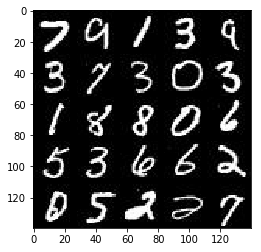

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

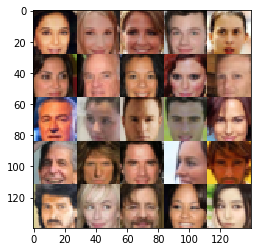

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels))
    z = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32)
    
    return real_input, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    
    with tf.variable_scope("discriminator", reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        conv1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2,  training=True)
        conv2 = tf.maximum(alpha * conv2, conv2)
        
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3,  training=True)
        conv3 = tf.maximum(alpha * conv3, conv3)

        flat  = tf.reshape(conv3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    
    with tf.variable_scope("generator", reuse=not is_train):
        x = tf.layers.dense(z, 7*7*512)
        x = tf.reshape(x, (-1, 7, 7, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        # 7x7x512
        
        conv1 = tf.layers.conv2d_transpose(x, 256, 5, strides=1, padding="same")
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha * conv1, conv1)
        # 14x14x256
        
        conv2 = tf.layers.conv2d_transpose(conv1, 128, 5, strides=2, padding="same")
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha * conv2, conv2)
        # 28x28x128
        
        logits = tf.layers.conv2d_transpose(conv2, out_channel_dim, 5, strides=2, padding="same")
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_real)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    show_every = 50
    print_every = 10
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 0.5767... Generator Loss: 1.2088
Epoch 0/2... Discriminator Loss: 2.1877... Generator Loss: 2.9844
Epoch 0/2... Discriminator Loss: 3.4147... Generator Loss: 0.0478
Epoch 0/2... Discriminator Loss: 0.6398... Generator Loss: 6.6165


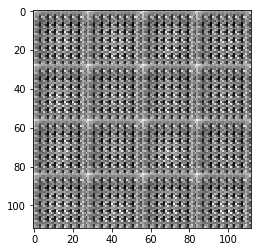

Epoch 0/2... Discriminator Loss: 0.1298... Generator Loss: 2.8932
Epoch 0/2... Discriminator Loss: 0.7903... Generator Loss: 0.7713
Epoch 0/2... Discriminator Loss: 0.4368... Generator Loss: 1.3056
Epoch 0/2... Discriminator Loss: 0.6148... Generator Loss: 1.5314
Epoch 0/2... Discriminator Loss: 0.7770... Generator Loss: 1.1727


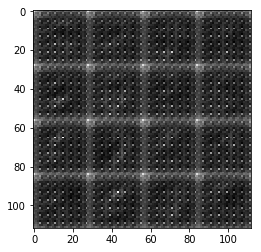

Epoch 0/2... Discriminator Loss: 1.1987... Generator Loss: 0.9248
Epoch 0/2... Discriminator Loss: 1.6162... Generator Loss: 0.3642
Epoch 0/2... Discriminator Loss: 1.7916... Generator Loss: 0.2965
Epoch 0/2... Discriminator Loss: 1.1588... Generator Loss: 0.6896
Epoch 0/2... Discriminator Loss: 1.5738... Generator Loss: 0.4099


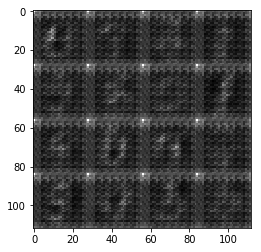

Epoch 0/2... Discriminator Loss: 0.9789... Generator Loss: 1.0938
Epoch 0/2... Discriminator Loss: 1.5449... Generator Loss: 0.3555
Epoch 0/2... Discriminator Loss: 1.0868... Generator Loss: 1.0857
Epoch 0/2... Discriminator Loss: 0.9777... Generator Loss: 0.8471
Epoch 0/2... Discriminator Loss: 1.1614... Generator Loss: 0.7228


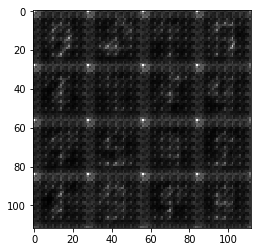

Epoch 0/2... Discriminator Loss: 1.1204... Generator Loss: 0.7018
Epoch 0/2... Discriminator Loss: 1.1521... Generator Loss: 1.5327
Epoch 0/2... Discriminator Loss: 0.8445... Generator Loss: 0.9288
Epoch 0/2... Discriminator Loss: 0.8645... Generator Loss: 0.8147
Epoch 0/2... Discriminator Loss: 1.0855... Generator Loss: 0.6373


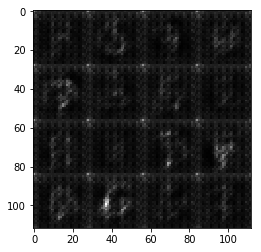

Epoch 0/2... Discriminator Loss: 1.5112... Generator Loss: 0.3577
Epoch 0/2... Discriminator Loss: 0.9339... Generator Loss: 1.0286
Epoch 0/2... Discriminator Loss: 0.8147... Generator Loss: 2.1269
Epoch 0/2... Discriminator Loss: 0.9143... Generator Loss: 1.0554
Epoch 0/2... Discriminator Loss: 0.9603... Generator Loss: 0.8580


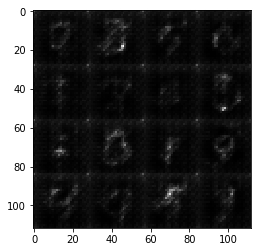

Epoch 0/2... Discriminator Loss: 1.3528... Generator Loss: 0.4437
Epoch 0/2... Discriminator Loss: 1.4743... Generator Loss: 0.3272
Epoch 0/2... Discriminator Loss: 0.7045... Generator Loss: 1.3520
Epoch 0/2... Discriminator Loss: 1.0951... Generator Loss: 0.6345
Epoch 0/2... Discriminator Loss: 0.9911... Generator Loss: 0.7707


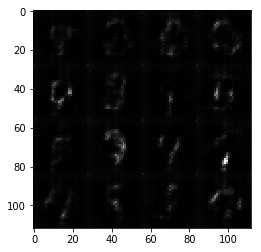

Epoch 0/2... Discriminator Loss: 0.8800... Generator Loss: 0.9562
Epoch 0/2... Discriminator Loss: 1.2959... Generator Loss: 0.4488
Epoch 0/2... Discriminator Loss: 1.0013... Generator Loss: 2.0926
Epoch 0/2... Discriminator Loss: 0.9419... Generator Loss: 1.1626
Epoch 0/2... Discriminator Loss: 0.9364... Generator Loss: 0.7635


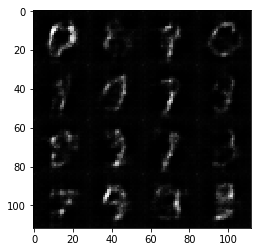

Epoch 0/2... Discriminator Loss: 1.0849... Generator Loss: 0.6440
Epoch 0/2... Discriminator Loss: 1.0620... Generator Loss: 0.7519
Epoch 0/2... Discriminator Loss: 1.3683... Generator Loss: 0.4082
Epoch 0/2... Discriminator Loss: 1.0976... Generator Loss: 0.9837
Epoch 0/2... Discriminator Loss: 1.2060... Generator Loss: 0.4872


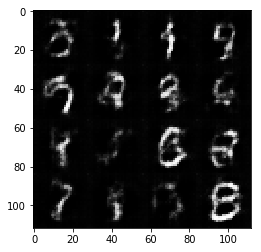

Epoch 0/2... Discriminator Loss: 1.1907... Generator Loss: 1.3524
Epoch 0/2... Discriminator Loss: 1.1790... Generator Loss: 0.8888
Epoch 0/2... Discriminator Loss: 1.3192... Generator Loss: 0.4676
Epoch 0/2... Discriminator Loss: 1.0051... Generator Loss: 1.0889
Epoch 0/2... Discriminator Loss: 0.9964... Generator Loss: 1.0432


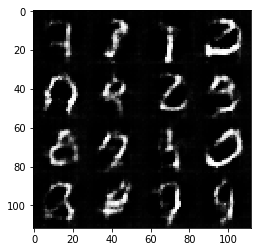

Epoch 0/2... Discriminator Loss: 1.1204... Generator Loss: 0.8167
Epoch 0/2... Discriminator Loss: 0.9150... Generator Loss: 1.1234
Epoch 0/2... Discriminator Loss: 0.9160... Generator Loss: 1.4789
Epoch 0/2... Discriminator Loss: 1.5662... Generator Loss: 0.3007
Epoch 0/2... Discriminator Loss: 0.8407... Generator Loss: 1.0301


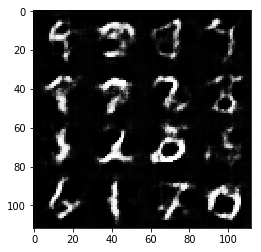

Epoch 0/2... Discriminator Loss: 0.7726... Generator Loss: 1.0629
Epoch 0/2... Discriminator Loss: 0.9956... Generator Loss: 0.8368
Epoch 0/2... Discriminator Loss: 1.0479... Generator Loss: 0.8909
Epoch 0/2... Discriminator Loss: 1.3186... Generator Loss: 0.4787
Epoch 0/2... Discriminator Loss: 0.9808... Generator Loss: 0.8940


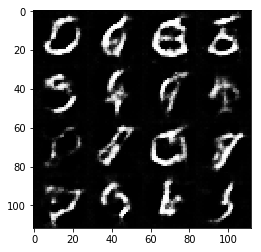

Epoch 0/2... Discriminator Loss: 0.8446... Generator Loss: 1.1470
Epoch 0/2... Discriminator Loss: 0.8550... Generator Loss: 1.5176
Epoch 0/2... Discriminator Loss: 1.4399... Generator Loss: 0.3724
Epoch 0/2... Discriminator Loss: 1.2996... Generator Loss: 0.4142
Epoch 0/2... Discriminator Loss: 1.0316... Generator Loss: 0.9322


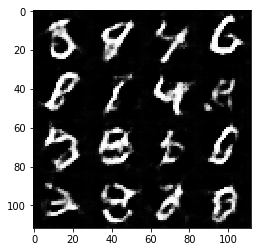

Epoch 0/2... Discriminator Loss: 1.4003... Generator Loss: 0.4046
Epoch 0/2... Discriminator Loss: 1.0311... Generator Loss: 0.9679
Epoch 0/2... Discriminator Loss: 1.1692... Generator Loss: 0.5546
Epoch 0/2... Discriminator Loss: 0.8253... Generator Loss: 1.2887
Epoch 0/2... Discriminator Loss: 1.0988... Generator Loss: 0.5909


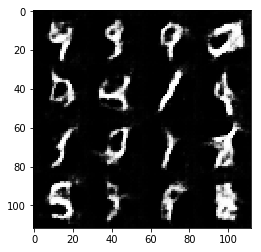

Epoch 0/2... Discriminator Loss: 0.8993... Generator Loss: 0.9246
Epoch 0/2... Discriminator Loss: 1.1664... Generator Loss: 1.4072
Epoch 0/2... Discriminator Loss: 1.1285... Generator Loss: 0.5410
Epoch 0/2... Discriminator Loss: 0.8377... Generator Loss: 1.4128
Epoch 0/2... Discriminator Loss: 1.0123... Generator Loss: 1.2896


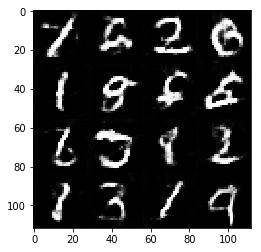

Epoch 0/2... Discriminator Loss: 1.1845... Generator Loss: 0.4765
Epoch 0/2... Discriminator Loss: 1.1378... Generator Loss: 0.5576
Epoch 0/2... Discriminator Loss: 1.0783... Generator Loss: 0.6247
Epoch 0/2... Discriminator Loss: 1.1351... Generator Loss: 0.5935
Epoch 0/2... Discriminator Loss: 1.2280... Generator Loss: 0.7457


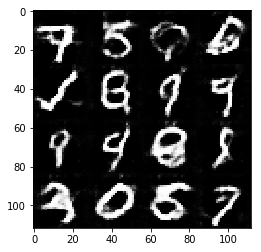

Epoch 0/2... Discriminator Loss: 0.9537... Generator Loss: 0.7752
Epoch 0/2... Discriminator Loss: 1.0681... Generator Loss: 0.7367
Epoch 0/2... Discriminator Loss: 0.9850... Generator Loss: 0.8880
Epoch 0/2... Discriminator Loss: 1.7437... Generator Loss: 0.2395
Epoch 0/2... Discriminator Loss: 1.0278... Generator Loss: 0.7003


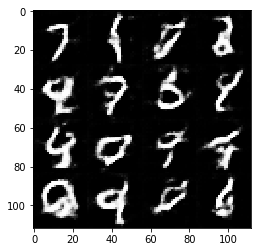

Epoch 0/2... Discriminator Loss: 0.8098... Generator Loss: 1.2779
Epoch 0/2... Discriminator Loss: 0.8620... Generator Loss: 1.1835
Epoch 0/2... Discriminator Loss: 0.8931... Generator Loss: 1.0200
Epoch 0/2... Discriminator Loss: 1.1205... Generator Loss: 0.5586
Epoch 0/2... Discriminator Loss: 0.9184... Generator Loss: 1.1071


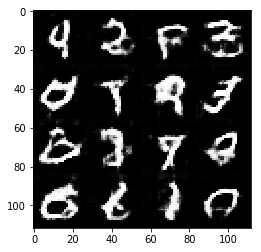

Epoch 0/2... Discriminator Loss: 0.8932... Generator Loss: 0.8569
Epoch 0/2... Discriminator Loss: 0.8038... Generator Loss: 1.3083
Epoch 0/2... Discriminator Loss: 1.3869... Generator Loss: 0.3900
Epoch 0/2... Discriminator Loss: 1.0096... Generator Loss: 0.7679
Epoch 0/2... Discriminator Loss: 1.1504... Generator Loss: 0.5296


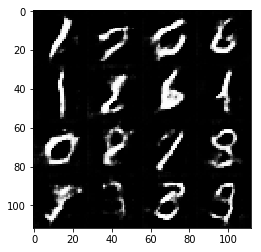

Epoch 0/2... Discriminator Loss: 1.2589... Generator Loss: 0.4345
Epoch 0/2... Discriminator Loss: 0.8446... Generator Loss: 1.1915
Epoch 0/2... Discriminator Loss: 1.1338... Generator Loss: 2.2147
Epoch 0/2... Discriminator Loss: 1.1509... Generator Loss: 0.5297
Epoch 0/2... Discriminator Loss: 1.2954... Generator Loss: 0.4388


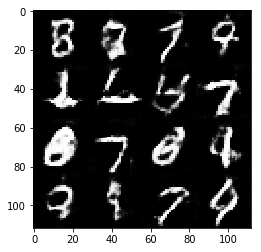

Epoch 0/2... Discriminator Loss: 1.3081... Generator Loss: 0.4432
Epoch 0/2... Discriminator Loss: 0.8133... Generator Loss: 0.8459
Epoch 0/2... Discriminator Loss: 0.8458... Generator Loss: 0.9118
Epoch 0/2... Discriminator Loss: 0.7948... Generator Loss: 1.1094
Epoch 0/2... Discriminator Loss: 1.3197... Generator Loss: 0.4001


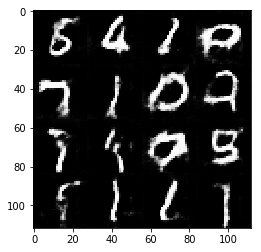

Epoch 0/2... Discriminator Loss: 1.3999... Generator Loss: 0.4308
Epoch 0/2... Discriminator Loss: 0.7960... Generator Loss: 1.0330
Epoch 0/2... Discriminator Loss: 0.8280... Generator Loss: 1.2499
Epoch 0/2... Discriminator Loss: 1.2629... Generator Loss: 0.5296
Epoch 0/2... Discriminator Loss: 0.9926... Generator Loss: 0.6989


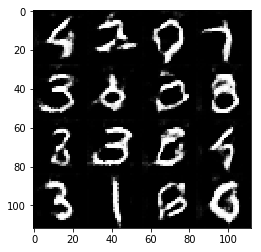

Epoch 0/2... Discriminator Loss: 1.2526... Generator Loss: 0.4510
Epoch 0/2... Discriminator Loss: 0.9436... Generator Loss: 0.8083
Epoch 0/2... Discriminator Loss: 1.1083... Generator Loss: 0.5477
Epoch 0/2... Discriminator Loss: 0.9505... Generator Loss: 0.9120
Epoch 0/2... Discriminator Loss: 0.9502... Generator Loss: 0.7034


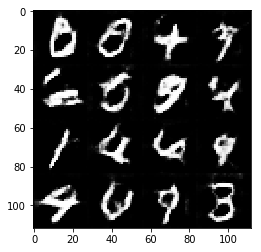

Epoch 0/2... Discriminator Loss: 1.1696... Generator Loss: 0.4969
Epoch 0/2... Discriminator Loss: 1.4002... Generator Loss: 0.3883
Epoch 0/2... Discriminator Loss: 0.8918... Generator Loss: 0.7936
Epoch 0/2... Discriminator Loss: 0.8206... Generator Loss: 0.9352
Epoch 0/2... Discriminator Loss: 1.0942... Generator Loss: 0.5566


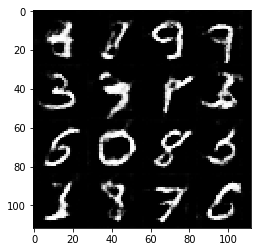

Epoch 0/2... Discriminator Loss: 1.1633... Generator Loss: 0.5681
Epoch 0/2... Discriminator Loss: 0.7078... Generator Loss: 1.4777
Epoch 0/2... Discriminator Loss: 1.2188... Generator Loss: 0.4743
Epoch 0/2... Discriminator Loss: 1.0836... Generator Loss: 0.5797
Epoch 0/2... Discriminator Loss: 0.8994... Generator Loss: 0.8359


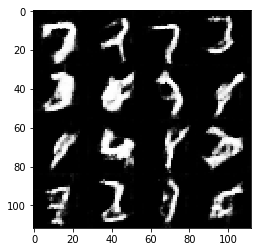

Epoch 0/2... Discriminator Loss: 1.2942... Generator Loss: 0.5229
Epoch 0/2... Discriminator Loss: 1.1955... Generator Loss: 0.5786
Epoch 0/2... Discriminator Loss: 0.7437... Generator Loss: 1.3092
Epoch 0/2... Discriminator Loss: 0.6936... Generator Loss: 1.3232
Epoch 0/2... Discriminator Loss: 1.2929... Generator Loss: 0.4084


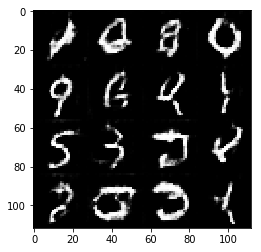

Epoch 0/2... Discriminator Loss: 0.7802... Generator Loss: 1.1429
Epoch 0/2... Discriminator Loss: 1.0307... Generator Loss: 0.7103
Epoch 0/2... Discriminator Loss: 1.0878... Generator Loss: 0.5838
Epoch 0/2... Discriminator Loss: 1.6548... Generator Loss: 0.2543
Epoch 0/2... Discriminator Loss: 1.1008... Generator Loss: 0.6959


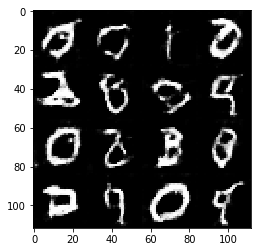

Epoch 0/2... Discriminator Loss: 0.7978... Generator Loss: 1.5791
Epoch 0/2... Discriminator Loss: 1.2144... Generator Loss: 0.4530
Epoch 0/2... Discriminator Loss: 0.7371... Generator Loss: 1.3381
Epoch 0/2... Discriminator Loss: 0.7235... Generator Loss: 1.1836
Epoch 0/2... Discriminator Loss: 1.2922... Generator Loss: 0.4361


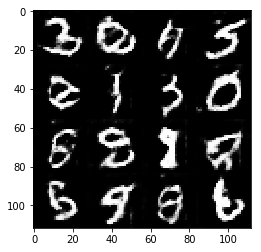

Epoch 0/2... Discriminator Loss: 0.9760... Generator Loss: 0.8310
Epoch 0/2... Discriminator Loss: 0.7892... Generator Loss: 0.9454
Epoch 0/2... Discriminator Loss: 0.6478... Generator Loss: 1.0064
Epoch 0/2... Discriminator Loss: 0.8285... Generator Loss: 0.7794
Epoch 0/2... Discriminator Loss: 1.1550... Generator Loss: 0.5642


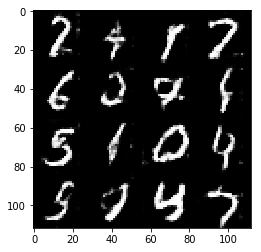

Epoch 0/2... Discriminator Loss: 0.9849... Generator Loss: 0.6589
Epoch 0/2... Discriminator Loss: 2.2706... Generator Loss: 0.1699
Epoch 0/2... Discriminator Loss: 0.8486... Generator Loss: 1.6418
Epoch 0/2... Discriminator Loss: 1.1119... Generator Loss: 0.6624
Epoch 0/2... Discriminator Loss: 1.0005... Generator Loss: 0.6580


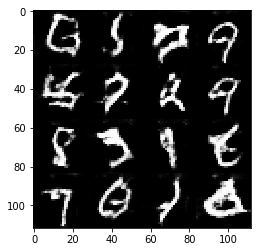

Epoch 0/2... Discriminator Loss: 1.2865... Generator Loss: 0.4591
Epoch 0/2... Discriminator Loss: 0.8415... Generator Loss: 0.8861
Epoch 0/2... Discriminator Loss: 0.8504... Generator Loss: 0.6950
Epoch 0/2... Discriminator Loss: 1.2288... Generator Loss: 0.5285
Epoch 0/2... Discriminator Loss: 0.9966... Generator Loss: 0.7106


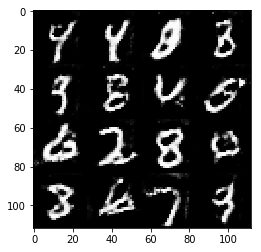

Epoch 0/2... Discriminator Loss: 0.9202... Generator Loss: 1.6846
Epoch 0/2... Discriminator Loss: 0.9741... Generator Loss: 0.6515
Epoch 0/2... Discriminator Loss: 0.8477... Generator Loss: 0.8111
Epoch 0/2... Discriminator Loss: 1.4123... Generator Loss: 0.4404
Epoch 0/2... Discriminator Loss: 1.2799... Generator Loss: 0.4659


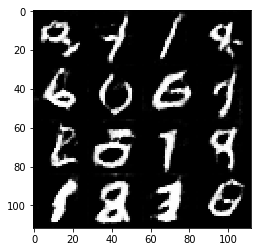

Epoch 0/2... Discriminator Loss: 1.0478... Generator Loss: 0.7454
Epoch 0/2... Discriminator Loss: 1.2171... Generator Loss: 0.4706
Epoch 0/2... Discriminator Loss: 0.8774... Generator Loss: 0.7725
Epoch 0/2... Discriminator Loss: 0.5072... Generator Loss: 1.5130
Epoch 0/2... Discriminator Loss: 0.9362... Generator Loss: 0.6496


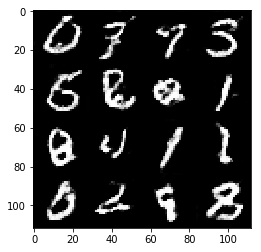

Epoch 0/2... Discriminator Loss: 1.3577... Generator Loss: 0.4559
Epoch 0/2... Discriminator Loss: 0.8889... Generator Loss: 0.9068
Epoch 0/2... Discriminator Loss: 0.7235... Generator Loss: 0.9726
Epoch 0/2... Discriminator Loss: 0.7478... Generator Loss: 1.2209
Epoch 0/2... Discriminator Loss: 1.2964... Generator Loss: 0.4189


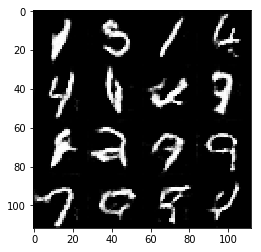

Epoch 0/2... Discriminator Loss: 0.7480... Generator Loss: 1.8845
Epoch 0/2... Discriminator Loss: 1.2004... Generator Loss: 0.5173
Epoch 0/2... Discriminator Loss: 0.8351... Generator Loss: 0.9210
Epoch 0/2... Discriminator Loss: 0.8032... Generator Loss: 0.7977
Epoch 0/2... Discriminator Loss: 0.9033... Generator Loss: 0.8274


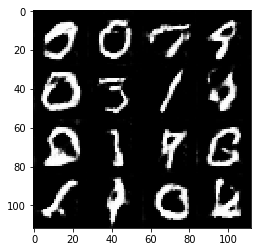

Epoch 0/2... Discriminator Loss: 0.5865... Generator Loss: 1.2612
Epoch 0/2... Discriminator Loss: 1.2990... Generator Loss: 0.4865
Epoch 0/2... Discriminator Loss: 0.6994... Generator Loss: 0.9783
Epoch 0/2... Discriminator Loss: 0.6386... Generator Loss: 1.2593
Epoch 0/2... Discriminator Loss: 0.7281... Generator Loss: 0.9923


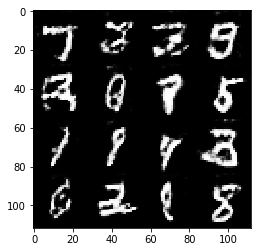

Epoch 0/2... Discriminator Loss: 0.7181... Generator Loss: 0.9912
Epoch 0/2... Discriminator Loss: 0.6649... Generator Loss: 1.9196
Epoch 0/2... Discriminator Loss: 0.9567... Generator Loss: 0.7103
Epoch 0/2... Discriminator Loss: 0.5380... Generator Loss: 1.7710
Epoch 0/2... Discriminator Loss: 0.6835... Generator Loss: 1.2010


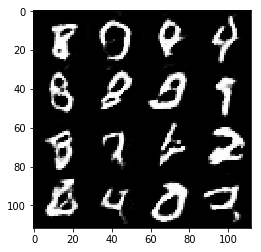

Epoch 0/2... Discriminator Loss: 1.7014... Generator Loss: 0.2665
Epoch 0/2... Discriminator Loss: 0.8360... Generator Loss: 0.8659
Epoch 0/2... Discriminator Loss: 0.9694... Generator Loss: 0.7684
Epoch 1/2... Discriminator Loss: 1.3580... Generator Loss: 2.8834
Epoch 1/2... Discriminator Loss: 0.6610... Generator Loss: 1.2745


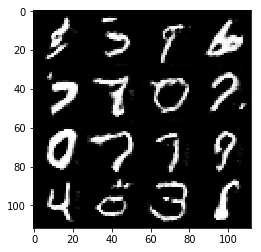

Epoch 1/2... Discriminator Loss: 0.8359... Generator Loss: 0.7510
Epoch 1/2... Discriminator Loss: 0.6426... Generator Loss: 1.4941
Epoch 1/2... Discriminator Loss: 0.4941... Generator Loss: 1.5965
Epoch 1/2... Discriminator Loss: 0.6635... Generator Loss: 1.1946
Epoch 1/2... Discriminator Loss: 0.3824... Generator Loss: 1.6292


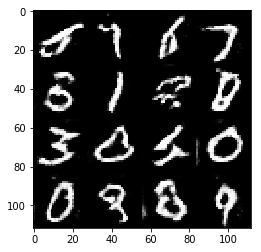

Epoch 1/2... Discriminator Loss: 0.9976... Generator Loss: 0.6768
Epoch 1/2... Discriminator Loss: 0.4063... Generator Loss: 1.9705
Epoch 1/2... Discriminator Loss: 1.1945... Generator Loss: 0.5286
Epoch 1/2... Discriminator Loss: 0.5945... Generator Loss: 1.3850
Epoch 1/2... Discriminator Loss: 0.6277... Generator Loss: 1.2648


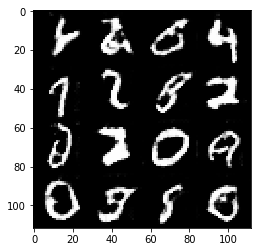

Epoch 1/2... Discriminator Loss: 0.6198... Generator Loss: 1.1985
Epoch 1/2... Discriminator Loss: 0.7787... Generator Loss: 0.9586
Epoch 1/2... Discriminator Loss: 1.9969... Generator Loss: 5.5465
Epoch 1/2... Discriminator Loss: 0.4472... Generator Loss: 2.1017
Epoch 1/2... Discriminator Loss: 0.6030... Generator Loss: 1.2629


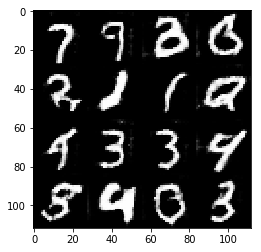

Epoch 1/2... Discriminator Loss: 0.8401... Generator Loss: 0.7821
Epoch 1/2... Discriminator Loss: 0.6250... Generator Loss: 1.0564
Epoch 1/2... Discriminator Loss: 0.5565... Generator Loss: 1.3713
Epoch 1/2... Discriminator Loss: 0.8954... Generator Loss: 0.8548
Epoch 1/2... Discriminator Loss: 1.9781... Generator Loss: 0.2713


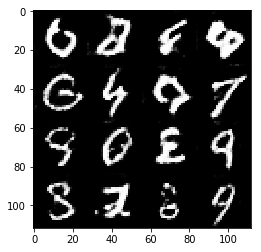

Epoch 1/2... Discriminator Loss: 0.8694... Generator Loss: 1.1853
Epoch 1/2... Discriminator Loss: 0.5045... Generator Loss: 1.2591
Epoch 1/2... Discriminator Loss: 0.9252... Generator Loss: 0.7509
Epoch 1/2... Discriminator Loss: 0.6030... Generator Loss: 1.0143
Epoch 1/2... Discriminator Loss: 0.7592... Generator Loss: 1.0037


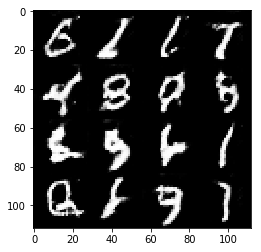

Epoch 1/2... Discriminator Loss: 1.6449... Generator Loss: 0.3674
Epoch 1/2... Discriminator Loss: 0.6729... Generator Loss: 1.1970
Epoch 1/2... Discriminator Loss: 1.1318... Generator Loss: 0.5429
Epoch 1/2... Discriminator Loss: 1.1642... Generator Loss: 0.5289
Epoch 1/2... Discriminator Loss: 0.5192... Generator Loss: 1.7694


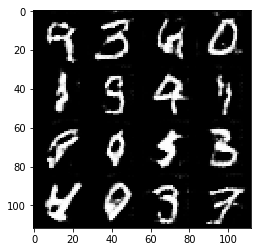

Epoch 1/2... Discriminator Loss: 0.4628... Generator Loss: 1.4190
Epoch 1/2... Discriminator Loss: 0.7970... Generator Loss: 0.7824
Epoch 1/2... Discriminator Loss: 0.7756... Generator Loss: 0.8784
Epoch 1/2... Discriminator Loss: 0.8276... Generator Loss: 0.7944
Epoch 1/2... Discriminator Loss: 0.9188... Generator Loss: 0.7747


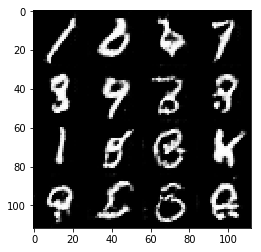

Epoch 1/2... Discriminator Loss: 0.7203... Generator Loss: 0.9882
Epoch 1/2... Discriminator Loss: 0.9896... Generator Loss: 0.5934
Epoch 1/2... Discriminator Loss: 0.6217... Generator Loss: 1.1663
Epoch 1/2... Discriminator Loss: 2.3149... Generator Loss: 0.1527
Epoch 1/2... Discriminator Loss: 0.8951... Generator Loss: 0.7445


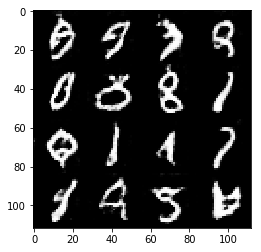

Epoch 1/2... Discriminator Loss: 1.5888... Generator Loss: 0.3008
Epoch 1/2... Discriminator Loss: 2.0114... Generator Loss: 0.2275
Epoch 1/2... Discriminator Loss: 1.0175... Generator Loss: 2.7443
Epoch 1/2... Discriminator Loss: 0.8536... Generator Loss: 1.2082
Epoch 1/2... Discriminator Loss: 0.3997... Generator Loss: 1.4895


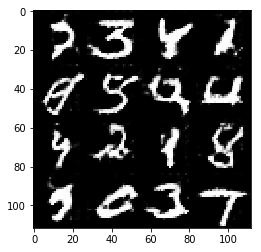

Epoch 1/2... Discriminator Loss: 0.8333... Generator Loss: 0.9198
Epoch 1/2... Discriminator Loss: 0.6183... Generator Loss: 1.4998
Epoch 1/2... Discriminator Loss: 1.0765... Generator Loss: 3.9129
Epoch 1/2... Discriminator Loss: 0.4310... Generator Loss: 1.6923
Epoch 1/2... Discriminator Loss: 0.9282... Generator Loss: 0.7298


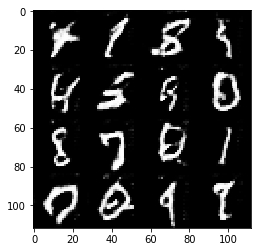

Epoch 1/2... Discriminator Loss: 0.8580... Generator Loss: 0.7456
Epoch 1/2... Discriminator Loss: 0.7084... Generator Loss: 1.9449
Epoch 1/2... Discriminator Loss: 0.6008... Generator Loss: 1.2638
Epoch 1/2... Discriminator Loss: 1.5761... Generator Loss: 0.3236
Epoch 1/2... Discriminator Loss: 0.6431... Generator Loss: 1.1523


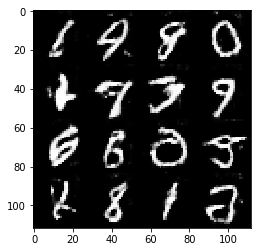

Epoch 1/2... Discriminator Loss: 0.7629... Generator Loss: 1.0402
Epoch 1/2... Discriminator Loss: 0.8205... Generator Loss: 0.8709
Epoch 1/2... Discriminator Loss: 0.6304... Generator Loss: 1.0117
Epoch 1/2... Discriminator Loss: 0.9833... Generator Loss: 0.5735
Epoch 1/2... Discriminator Loss: 0.9280... Generator Loss: 0.7185


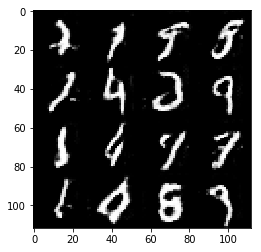

Epoch 1/2... Discriminator Loss: 1.5445... Generator Loss: 0.3517
Epoch 1/2... Discriminator Loss: 0.7834... Generator Loss: 1.1388
Epoch 1/2... Discriminator Loss: 0.3850... Generator Loss: 1.4799
Epoch 1/2... Discriminator Loss: 1.0027... Generator Loss: 0.6080
Epoch 1/2... Discriminator Loss: 0.6063... Generator Loss: 1.1630


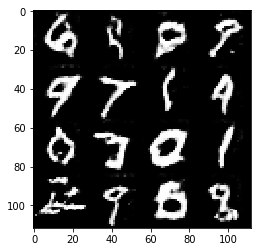

Epoch 1/2... Discriminator Loss: 0.5463... Generator Loss: 1.7754
Epoch 1/2... Discriminator Loss: 0.5083... Generator Loss: 2.1756
Epoch 1/2... Discriminator Loss: 0.4087... Generator Loss: 1.7554
Epoch 1/2... Discriminator Loss: 0.8403... Generator Loss: 0.9254
Epoch 1/2... Discriminator Loss: 0.5550... Generator Loss: 1.3317


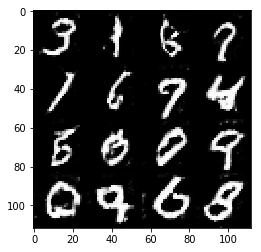

Epoch 1/2... Discriminator Loss: 0.7443... Generator Loss: 0.8684
Epoch 1/2... Discriminator Loss: 0.5258... Generator Loss: 1.3518
Epoch 1/2... Discriminator Loss: 0.4836... Generator Loss: 1.3422
Epoch 1/2... Discriminator Loss: 0.5542... Generator Loss: 2.0067
Epoch 1/2... Discriminator Loss: 0.4029... Generator Loss: 2.5519


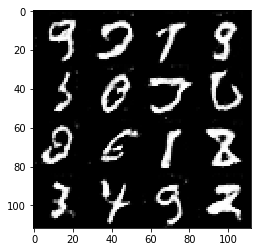

Epoch 1/2... Discriminator Loss: 1.0172... Generator Loss: 0.7781
Epoch 1/2... Discriminator Loss: 0.6275... Generator Loss: 1.0484
Epoch 1/2... Discriminator Loss: 0.5890... Generator Loss: 1.2897
Epoch 1/2... Discriminator Loss: 0.5201... Generator Loss: 1.2673
Epoch 1/2... Discriminator Loss: 0.6257... Generator Loss: 1.0515


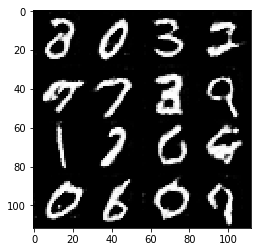

Epoch 1/2... Discriminator Loss: 0.4027... Generator Loss: 1.7132
Epoch 1/2... Discriminator Loss: 0.5371... Generator Loss: 1.3345
Epoch 1/2... Discriminator Loss: 1.7888... Generator Loss: 0.2685
Epoch 1/2... Discriminator Loss: 1.0063... Generator Loss: 1.8728
Epoch 1/2... Discriminator Loss: 0.5807... Generator Loss: 1.3258


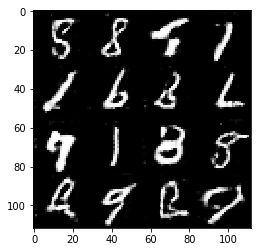

Epoch 1/2... Discriminator Loss: 0.5159... Generator Loss: 1.5512
Epoch 1/2... Discriminator Loss: 0.4535... Generator Loss: 2.1662
Epoch 1/2... Discriminator Loss: 1.0676... Generator Loss: 0.6951
Epoch 1/2... Discriminator Loss: 0.6778... Generator Loss: 0.9780
Epoch 1/2... Discriminator Loss: 0.8543... Generator Loss: 0.9455


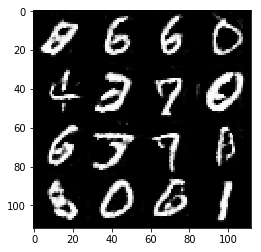

Epoch 1/2... Discriminator Loss: 0.7094... Generator Loss: 2.3483
Epoch 1/2... Discriminator Loss: 0.4730... Generator Loss: 2.0950
Epoch 1/2... Discriminator Loss: 0.7749... Generator Loss: 0.8874
Epoch 1/2... Discriminator Loss: 0.3860... Generator Loss: 2.4179
Epoch 1/2... Discriminator Loss: 0.8810... Generator Loss: 0.7429


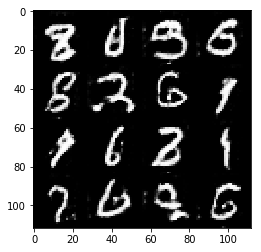

Epoch 1/2... Discriminator Loss: 0.6016... Generator Loss: 1.9478
Epoch 1/2... Discriminator Loss: 0.8421... Generator Loss: 0.8458
Epoch 1/2... Discriminator Loss: 0.7742... Generator Loss: 0.9745
Epoch 1/2... Discriminator Loss: 0.5529... Generator Loss: 1.1456
Epoch 1/2... Discriminator Loss: 0.7114... Generator Loss: 0.8936


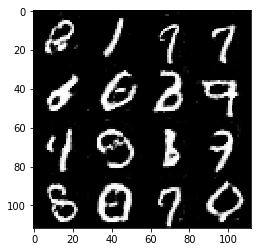

Epoch 1/2... Discriminator Loss: 0.5230... Generator Loss: 1.2292
Epoch 1/2... Discriminator Loss: 0.7688... Generator Loss: 0.7909
Epoch 1/2... Discriminator Loss: 0.5438... Generator Loss: 1.2691
Epoch 1/2... Discriminator Loss: 0.5235... Generator Loss: 1.9681
Epoch 1/2... Discriminator Loss: 1.1378... Generator Loss: 0.6543


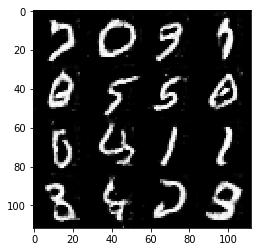

Epoch 1/2... Discriminator Loss: 0.6768... Generator Loss: 1.6412
Epoch 1/2... Discriminator Loss: 0.6864... Generator Loss: 1.0317
Epoch 1/2... Discriminator Loss: 0.7414... Generator Loss: 1.7137
Epoch 1/2... Discriminator Loss: 1.1603... Generator Loss: 0.6840
Epoch 1/2... Discriminator Loss: 0.5617... Generator Loss: 1.2896


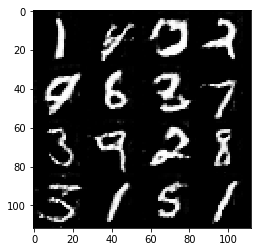

Epoch 1/2... Discriminator Loss: 0.5551... Generator Loss: 2.0959
Epoch 1/2... Discriminator Loss: 1.4088... Generator Loss: 0.4433
Epoch 1/2... Discriminator Loss: 0.8746... Generator Loss: 0.7360
Epoch 1/2... Discriminator Loss: 1.2240... Generator Loss: 0.4814
Epoch 1/2... Discriminator Loss: 0.6865... Generator Loss: 1.0006


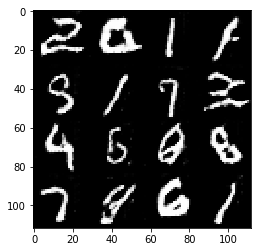

Epoch 1/2... Discriminator Loss: 1.0085... Generator Loss: 0.6516
Epoch 1/2... Discriminator Loss: 0.4289... Generator Loss: 1.4874
Epoch 1/2... Discriminator Loss: 1.2105... Generator Loss: 0.5439
Epoch 1/2... Discriminator Loss: 0.5802... Generator Loss: 1.1665
Epoch 1/2... Discriminator Loss: 0.4413... Generator Loss: 1.5250


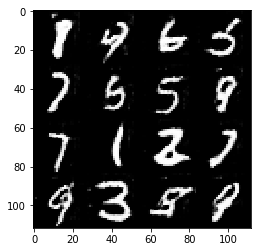

Epoch 1/2... Discriminator Loss: 0.7856... Generator Loss: 1.0096
Epoch 1/2... Discriminator Loss: 1.7310... Generator Loss: 0.2992
Epoch 1/2... Discriminator Loss: 0.8106... Generator Loss: 0.7736
Epoch 1/2... Discriminator Loss: 0.3633... Generator Loss: 1.8102
Epoch 1/2... Discriminator Loss: 0.6892... Generator Loss: 3.7135


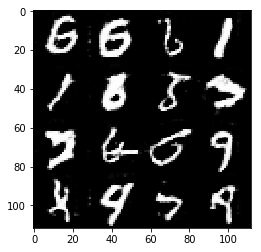

Epoch 1/2... Discriminator Loss: 1.0025... Generator Loss: 0.6543
Epoch 1/2... Discriminator Loss: 0.4400... Generator Loss: 1.4777
Epoch 1/2... Discriminator Loss: 1.2741... Generator Loss: 0.4372
Epoch 1/2... Discriminator Loss: 0.4040... Generator Loss: 1.5769
Epoch 1/2... Discriminator Loss: 0.4390... Generator Loss: 1.4249


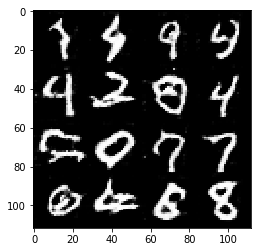

Epoch 1/2... Discriminator Loss: 0.8835... Generator Loss: 0.9140
Epoch 1/2... Discriminator Loss: 1.9765... Generator Loss: 0.2322
Epoch 1/2... Discriminator Loss: 1.0573... Generator Loss: 0.5627
Epoch 1/2... Discriminator Loss: 0.8515... Generator Loss: 0.8864
Epoch 1/2... Discriminator Loss: 0.5104... Generator Loss: 1.3740


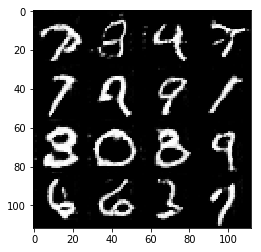

Epoch 1/2... Discriminator Loss: 0.4255... Generator Loss: 1.6877
Epoch 1/2... Discriminator Loss: 0.3619... Generator Loss: 1.7115
Epoch 1/2... Discriminator Loss: 0.4606... Generator Loss: 1.4620
Epoch 1/2... Discriminator Loss: 0.4379... Generator Loss: 2.6778
Epoch 1/2... Discriminator Loss: 0.5469... Generator Loss: 1.2464


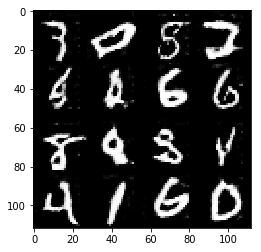

Epoch 1/2... Discriminator Loss: 0.9777... Generator Loss: 0.6032
Epoch 1/2... Discriminator Loss: 0.4508... Generator Loss: 1.7803
Epoch 1/2... Discriminator Loss: 0.5090... Generator Loss: 1.1028
Epoch 1/2... Discriminator Loss: 0.6234... Generator Loss: 1.1205
Epoch 1/2... Discriminator Loss: 0.8744... Generator Loss: 0.7808


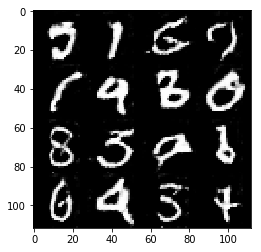

Epoch 1/2... Discriminator Loss: 1.0159... Generator Loss: 4.8020
Epoch 1/2... Discriminator Loss: 0.5168... Generator Loss: 2.0842
Epoch 1/2... Discriminator Loss: 0.7853... Generator Loss: 0.9399
Epoch 1/2... Discriminator Loss: 0.8247... Generator Loss: 0.7518
Epoch 1/2... Discriminator Loss: 0.5987... Generator Loss: 1.6305


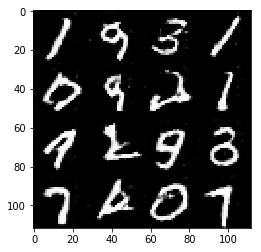

Epoch 1/2... Discriminator Loss: 0.3672... Generator Loss: 1.5826
Epoch 1/2... Discriminator Loss: 0.3984... Generator Loss: 1.8807
Epoch 1/2... Discriminator Loss: 0.3741... Generator Loss: 1.5673
Epoch 1/2... Discriminator Loss: 0.3975... Generator Loss: 1.5385
Epoch 1/2... Discriminator Loss: 0.7432... Generator Loss: 0.8579


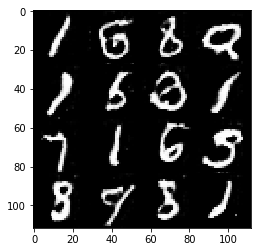

Epoch 1/2... Discriminator Loss: 0.5341... Generator Loss: 1.2505
Epoch 1/2... Discriminator Loss: 0.4092... Generator Loss: 1.5408
Epoch 1/2... Discriminator Loss: 0.9156... Generator Loss: 0.7684
Epoch 1/2... Discriminator Loss: 0.9233... Generator Loss: 0.8304
Epoch 1/2... Discriminator Loss: 0.4662... Generator Loss: 1.4073


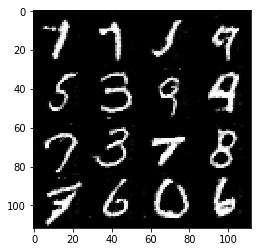

Epoch 1/2... Discriminator Loss: 0.5771... Generator Loss: 1.1627
Epoch 1/2... Discriminator Loss: 0.7334... Generator Loss: 1.0613
Epoch 1/2... Discriminator Loss: 0.5185... Generator Loss: 1.3183
Epoch 1/2... Discriminator Loss: 0.6177... Generator Loss: 1.2030
Epoch 1/2... Discriminator Loss: 4.1684... Generator Loss: 0.0799


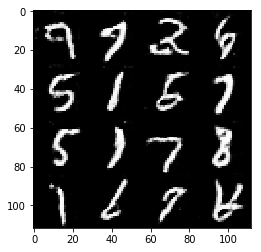

Epoch 1/2... Discriminator Loss: 1.0069... Generator Loss: 0.6428
Epoch 1/2... Discriminator Loss: 0.6775... Generator Loss: 1.0938
Epoch 1/2... Discriminator Loss: 0.4679... Generator Loss: 1.5200
Epoch 1/2... Discriminator Loss: 0.5909... Generator Loss: 1.0996
Epoch 1/2... Discriminator Loss: 0.6343... Generator Loss: 1.0211


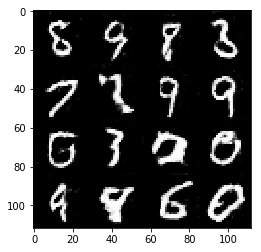

Epoch 1/2... Discriminator Loss: 0.6183... Generator Loss: 1.0919
Epoch 1/2... Discriminator Loss: 0.5776... Generator Loss: 1.2278
Epoch 1/2... Discriminator Loss: 0.4205... Generator Loss: 1.4755
Epoch 1/2... Discriminator Loss: 0.3537... Generator Loss: 2.2502
Epoch 1/2... Discriminator Loss: 1.2818... Generator Loss: 0.4595


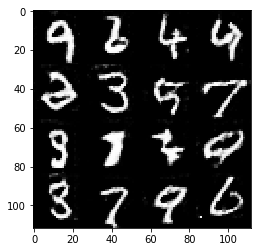

Epoch 1/2... Discriminator Loss: 0.5092... Generator Loss: 1.3218
Epoch 1/2... Discriminator Loss: 0.7831... Generator Loss: 0.9320
Epoch 1/2... Discriminator Loss: 0.4525... Generator Loss: 1.9954
Epoch 1/2... Discriminator Loss: 0.6778... Generator Loss: 0.9007
Epoch 1/2... Discriminator Loss: 0.3317... Generator Loss: 1.6000


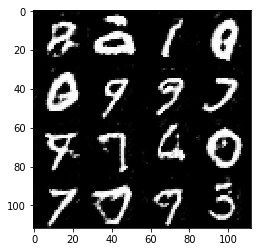

Epoch 1/2... Discriminator Loss: 0.4733... Generator Loss: 1.2519
Epoch 1/2... Discriminator Loss: 0.4798... Generator Loss: 1.3699
Epoch 1/2... Discriminator Loss: 1.0579... Generator Loss: 0.7197
Epoch 1/2... Discriminator Loss: 0.5028... Generator Loss: 1.2912


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 2.5541... Generator Loss: 0.1287
Epoch 0/1... Discriminator Loss: 0.7428... Generator Loss: 1.0322
Epoch 0/1... Discriminator Loss: 0.5853... Generator Loss: 6.4324
Epoch 0/1... Discriminator Loss: 0.2711... Generator Loss: 3.3913


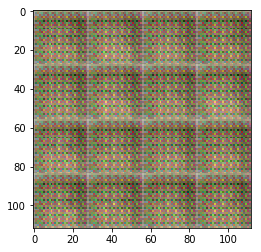

Epoch 0/1... Discriminator Loss: 3.1293... Generator Loss: 0.0546
Epoch 0/1... Discriminator Loss: 2.4248... Generator Loss: 0.1228
Epoch 0/1... Discriminator Loss: 0.6055... Generator Loss: 3.1523
Epoch 0/1... Discriminator Loss: 0.4033... Generator Loss: 3.8876
Epoch 0/1... Discriminator Loss: 0.4339... Generator Loss: 2.2228


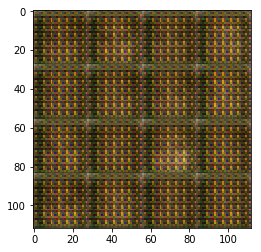

Epoch 0/1... Discriminator Loss: 0.8716... Generator Loss: 0.7634
Epoch 0/1... Discriminator Loss: 0.8487... Generator Loss: 1.0126
Epoch 0/1... Discriminator Loss: 1.0078... Generator Loss: 0.8883
Epoch 0/1... Discriminator Loss: 1.2379... Generator Loss: 0.5962
Epoch 0/1... Discriminator Loss: 0.8214... Generator Loss: 1.2079


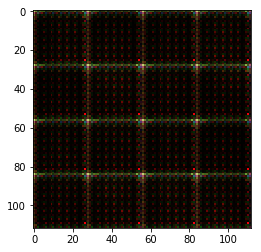

Epoch 0/1... Discriminator Loss: 0.6527... Generator Loss: 1.1636
Epoch 0/1... Discriminator Loss: 1.2923... Generator Loss: 0.4438
Epoch 0/1... Discriminator Loss: 0.8247... Generator Loss: 1.1123
Epoch 0/1... Discriminator Loss: 0.8783... Generator Loss: 0.9700
Epoch 0/1... Discriminator Loss: 1.3176... Generator Loss: 0.6212


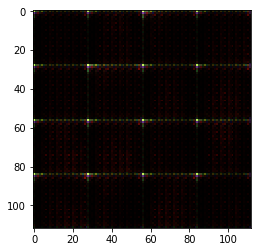

Epoch 0/1... Discriminator Loss: 0.9527... Generator Loss: 0.7039
Epoch 0/1... Discriminator Loss: 1.0225... Generator Loss: 1.5324
Epoch 0/1... Discriminator Loss: 0.7187... Generator Loss: 1.5094
Epoch 0/1... Discriminator Loss: 1.0518... Generator Loss: 1.3195
Epoch 0/1... Discriminator Loss: 1.1878... Generator Loss: 0.8458


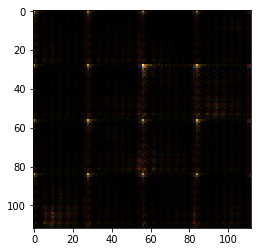

Epoch 0/1... Discriminator Loss: 1.0997... Generator Loss: 1.1184
Epoch 0/1... Discriminator Loss: 0.7105... Generator Loss: 1.7923
Epoch 0/1... Discriminator Loss: 1.0502... Generator Loss: 1.6059
Epoch 0/1... Discriminator Loss: 1.1910... Generator Loss: 0.5525
Epoch 0/1... Discriminator Loss: 1.1504... Generator Loss: 1.3932


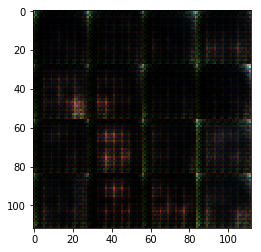

Epoch 0/1... Discriminator Loss: 1.1057... Generator Loss: 0.8681
Epoch 0/1... Discriminator Loss: 1.2910... Generator Loss: 0.5736
Epoch 0/1... Discriminator Loss: 1.0362... Generator Loss: 1.1618
Epoch 0/1... Discriminator Loss: 1.3618... Generator Loss: 0.4633
Epoch 0/1... Discriminator Loss: 1.3500... Generator Loss: 0.5125


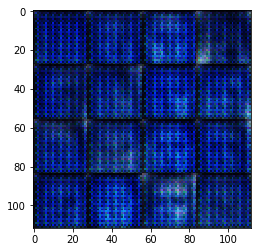

Epoch 0/1... Discriminator Loss: 1.2279... Generator Loss: 0.9767
Epoch 0/1... Discriminator Loss: 1.4351... Generator Loss: 0.5672
Epoch 0/1... Discriminator Loss: 1.5815... Generator Loss: 0.5551
Epoch 0/1... Discriminator Loss: 0.9331... Generator Loss: 0.8564
Epoch 0/1... Discriminator Loss: 1.5321... Generator Loss: 0.5691


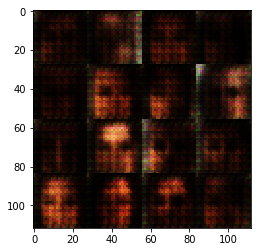

Epoch 0/1... Discriminator Loss: 1.6278... Generator Loss: 0.4293
Epoch 0/1... Discriminator Loss: 1.3686... Generator Loss: 0.4524
Epoch 0/1... Discriminator Loss: 1.2915... Generator Loss: 0.4770
Epoch 0/1... Discriminator Loss: 1.9620... Generator Loss: 0.3366
Epoch 0/1... Discriminator Loss: 1.6600... Generator Loss: 0.3845


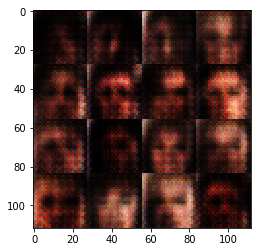

Epoch 0/1... Discriminator Loss: 1.2242... Generator Loss: 0.7709
Epoch 0/1... Discriminator Loss: 1.2342... Generator Loss: 0.9010
Epoch 0/1... Discriminator Loss: 1.0996... Generator Loss: 1.0416
Epoch 0/1... Discriminator Loss: 1.3138... Generator Loss: 0.7016
Epoch 0/1... Discriminator Loss: 1.1860... Generator Loss: 0.7124


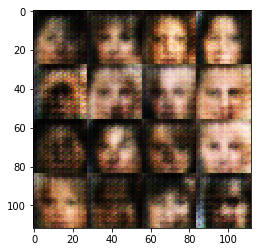

Epoch 0/1... Discriminator Loss: 1.1021... Generator Loss: 1.3835
Epoch 0/1... Discriminator Loss: 1.2953... Generator Loss: 0.6710
Epoch 0/1... Discriminator Loss: 1.3546... Generator Loss: 0.5525
Epoch 0/1... Discriminator Loss: 2.3937... Generator Loss: 0.1546
Epoch 0/1... Discriminator Loss: 1.3441... Generator Loss: 1.2571


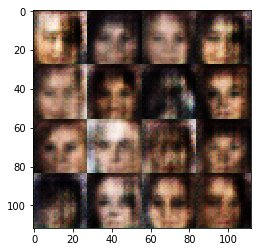

Epoch 0/1... Discriminator Loss: 1.2751... Generator Loss: 0.7244
Epoch 0/1... Discriminator Loss: 1.1207... Generator Loss: 0.9038
Epoch 0/1... Discriminator Loss: 1.2318... Generator Loss: 0.7194
Epoch 0/1... Discriminator Loss: 1.5357... Generator Loss: 1.2590
Epoch 0/1... Discriminator Loss: 1.4685... Generator Loss: 0.5357


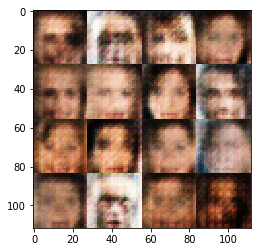

Epoch 0/1... Discriminator Loss: 1.3606... Generator Loss: 0.4828
Epoch 0/1... Discriminator Loss: 1.1714... Generator Loss: 0.7925
Epoch 0/1... Discriminator Loss: 1.5740... Generator Loss: 1.0997
Epoch 0/1... Discriminator Loss: 1.9314... Generator Loss: 0.2591
Epoch 0/1... Discriminator Loss: 1.3048... Generator Loss: 0.8290


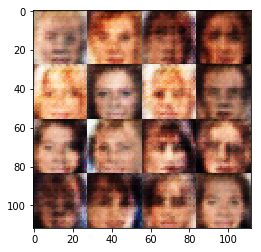

Epoch 0/1... Discriminator Loss: 1.0977... Generator Loss: 1.0028
Epoch 0/1... Discriminator Loss: 1.1222... Generator Loss: 1.1715
Epoch 0/1... Discriminator Loss: 1.1363... Generator Loss: 0.7170
Epoch 0/1... Discriminator Loss: 1.4375... Generator Loss: 0.5343
Epoch 0/1... Discriminator Loss: 1.2974... Generator Loss: 0.5513


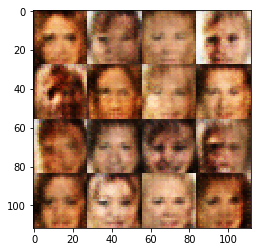

Epoch 0/1... Discriminator Loss: 1.5384... Generator Loss: 0.5605
Epoch 0/1... Discriminator Loss: 1.2912... Generator Loss: 0.5467
Epoch 0/1... Discriminator Loss: 1.2698... Generator Loss: 0.6450
Epoch 0/1... Discriminator Loss: 1.5301... Generator Loss: 0.4380
Epoch 0/1... Discriminator Loss: 1.5024... Generator Loss: 0.5020


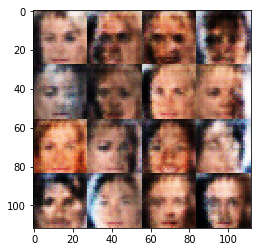

Epoch 0/1... Discriminator Loss: 1.1745... Generator Loss: 0.5781
Epoch 0/1... Discriminator Loss: 1.1340... Generator Loss: 0.8266
Epoch 0/1... Discriminator Loss: 1.3205... Generator Loss: 0.5085
Epoch 0/1... Discriminator Loss: 1.0172... Generator Loss: 0.7843
Epoch 0/1... Discriminator Loss: 1.2656... Generator Loss: 0.5851


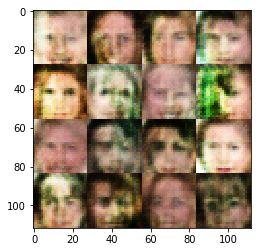

Epoch 0/1... Discriminator Loss: 1.6200... Generator Loss: 0.4021
Epoch 0/1... Discriminator Loss: 1.3244... Generator Loss: 0.6718
Epoch 0/1... Discriminator Loss: 1.3719... Generator Loss: 0.4811
Epoch 0/1... Discriminator Loss: 1.1985... Generator Loss: 1.0157
Epoch 0/1... Discriminator Loss: 1.1469... Generator Loss: 0.7879


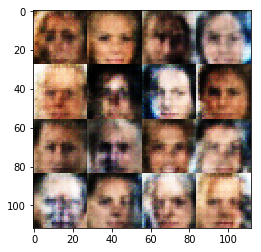

Epoch 0/1... Discriminator Loss: 1.5234... Generator Loss: 0.6202
Epoch 0/1... Discriminator Loss: 1.0291... Generator Loss: 0.9112
Epoch 0/1... Discriminator Loss: 1.1816... Generator Loss: 0.7605
Epoch 0/1... Discriminator Loss: 1.4686... Generator Loss: 0.4326
Epoch 0/1... Discriminator Loss: 1.4354... Generator Loss: 0.8106


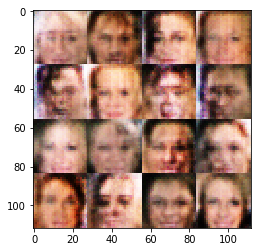

Epoch 0/1... Discriminator Loss: 1.2983... Generator Loss: 0.7341
Epoch 0/1... Discriminator Loss: 1.0616... Generator Loss: 0.8233
Epoch 0/1... Discriminator Loss: 1.3227... Generator Loss: 0.7014
Epoch 0/1... Discriminator Loss: 1.5177... Generator Loss: 0.5572
Epoch 0/1... Discriminator Loss: 1.3137... Generator Loss: 0.7809


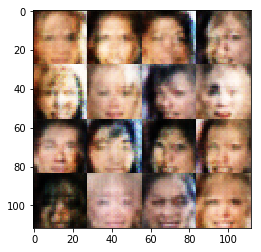

Epoch 0/1... Discriminator Loss: 1.3472... Generator Loss: 0.5319
Epoch 0/1... Discriminator Loss: 1.1968... Generator Loss: 1.0834
Epoch 0/1... Discriminator Loss: 1.0358... Generator Loss: 0.9435
Epoch 0/1... Discriminator Loss: 1.1579... Generator Loss: 0.6869
Epoch 0/1... Discriminator Loss: 1.8095... Generator Loss: 0.3042


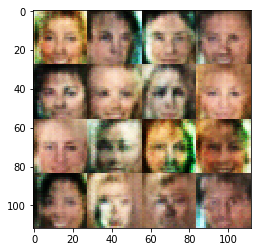

Epoch 0/1... Discriminator Loss: 1.2968... Generator Loss: 1.0873
Epoch 0/1... Discriminator Loss: 1.1794... Generator Loss: 1.2440
Epoch 0/1... Discriminator Loss: 1.3434... Generator Loss: 0.6394
Epoch 0/1... Discriminator Loss: 1.1868... Generator Loss: 0.5880
Epoch 0/1... Discriminator Loss: 1.0117... Generator Loss: 0.8312


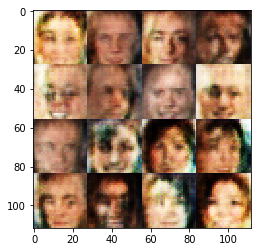

Epoch 0/1... Discriminator Loss: 1.1019... Generator Loss: 0.7304
Epoch 0/1... Discriminator Loss: 0.9076... Generator Loss: 1.2657
Epoch 0/1... Discriminator Loss: 1.1068... Generator Loss: 0.9893
Epoch 0/1... Discriminator Loss: 1.1636... Generator Loss: 1.1613
Epoch 0/1... Discriminator Loss: 0.9641... Generator Loss: 1.2730


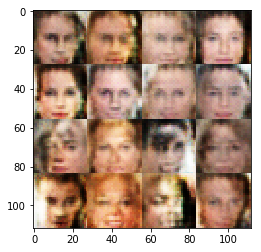

Epoch 0/1... Discriminator Loss: 1.2746... Generator Loss: 0.6182
Epoch 0/1... Discriminator Loss: 0.9438... Generator Loss: 1.1317
Epoch 0/1... Discriminator Loss: 1.0871... Generator Loss: 0.8440
Epoch 0/1... Discriminator Loss: 1.0133... Generator Loss: 0.8532
Epoch 0/1... Discriminator Loss: 1.2151... Generator Loss: 0.6087


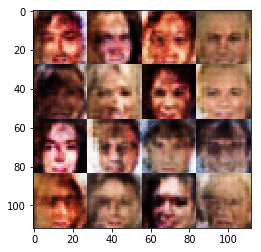

Epoch 0/1... Discriminator Loss: 1.1002... Generator Loss: 0.7932
Epoch 0/1... Discriminator Loss: 1.5475... Generator Loss: 0.4021
Epoch 0/1... Discriminator Loss: 1.3309... Generator Loss: 0.7726
Epoch 0/1... Discriminator Loss: 1.3105... Generator Loss: 0.7255
Epoch 0/1... Discriminator Loss: 1.6466... Generator Loss: 0.5556


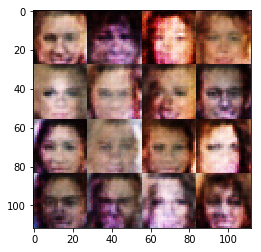

Epoch 0/1... Discriminator Loss: 1.1510... Generator Loss: 1.0567
Epoch 0/1... Discriminator Loss: 1.3559... Generator Loss: 1.0193
Epoch 0/1... Discriminator Loss: 1.2612... Generator Loss: 0.7860
Epoch 0/1... Discriminator Loss: 1.0377... Generator Loss: 1.1821
Epoch 0/1... Discriminator Loss: 1.0728... Generator Loss: 0.8069


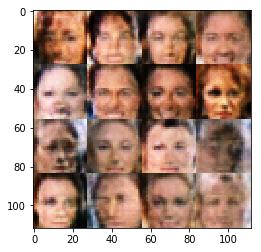

Epoch 0/1... Discriminator Loss: 1.1799... Generator Loss: 0.6018
Epoch 0/1... Discriminator Loss: 1.0713... Generator Loss: 0.7239
Epoch 0/1... Discriminator Loss: 1.0347... Generator Loss: 0.8607
Epoch 0/1... Discriminator Loss: 1.2161... Generator Loss: 0.5055
Epoch 0/1... Discriminator Loss: 1.1997... Generator Loss: 0.9095


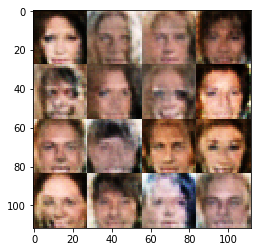

Epoch 0/1... Discriminator Loss: 1.0431... Generator Loss: 0.9231
Epoch 0/1... Discriminator Loss: 1.1595... Generator Loss: 0.7930
Epoch 0/1... Discriminator Loss: 1.1616... Generator Loss: 0.8806
Epoch 0/1... Discriminator Loss: 1.3879... Generator Loss: 0.4698
Epoch 0/1... Discriminator Loss: 1.3538... Generator Loss: 1.1658


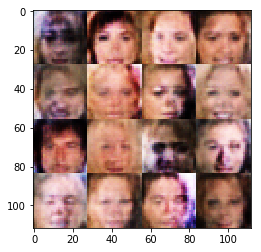

Epoch 0/1... Discriminator Loss: 1.0671... Generator Loss: 1.0883
Epoch 0/1... Discriminator Loss: 1.1608... Generator Loss: 0.7044
Epoch 0/1... Discriminator Loss: 0.9973... Generator Loss: 1.0129
Epoch 0/1... Discriminator Loss: 1.0585... Generator Loss: 0.7460
Epoch 0/1... Discriminator Loss: 1.4726... Generator Loss: 0.3893


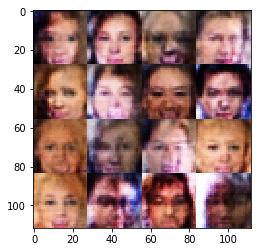

Epoch 0/1... Discriminator Loss: 1.8521... Generator Loss: 0.2248
Epoch 0/1... Discriminator Loss: 1.3269... Generator Loss: 1.2105
Epoch 0/1... Discriminator Loss: 1.1059... Generator Loss: 1.1716
Epoch 0/1... Discriminator Loss: 1.1569... Generator Loss: 0.9093
Epoch 0/1... Discriminator Loss: 1.5960... Generator Loss: 0.3498


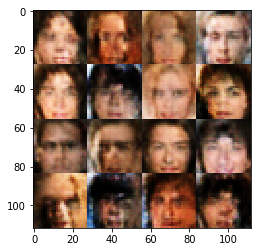

Epoch 0/1... Discriminator Loss: 1.1751... Generator Loss: 0.8142
Epoch 0/1... Discriminator Loss: 1.5785... Generator Loss: 0.3585
Epoch 0/1... Discriminator Loss: 0.8471... Generator Loss: 1.2128
Epoch 0/1... Discriminator Loss: 1.1284... Generator Loss: 0.6673
Epoch 0/1... Discriminator Loss: 1.2464... Generator Loss: 0.6200


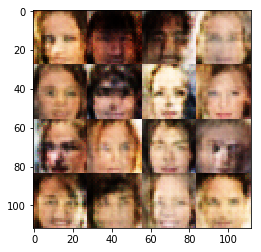

Epoch 0/1... Discriminator Loss: 0.8862... Generator Loss: 1.4637
Epoch 0/1... Discriminator Loss: 1.0404... Generator Loss: 0.7987
Epoch 0/1... Discriminator Loss: 1.3373... Generator Loss: 0.4872
Epoch 0/1... Discriminator Loss: 0.9197... Generator Loss: 1.1764
Epoch 0/1... Discriminator Loss: 1.1696... Generator Loss: 0.6319


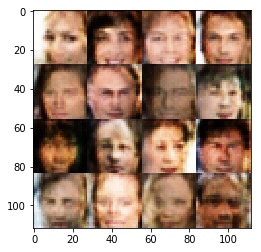

Epoch 0/1... Discriminator Loss: 1.2245... Generator Loss: 0.9073
Epoch 0/1... Discriminator Loss: 1.0619... Generator Loss: 1.5816
Epoch 0/1... Discriminator Loss: 1.2124... Generator Loss: 0.8955
Epoch 0/1... Discriminator Loss: 1.5472... Generator Loss: 0.3580
Epoch 0/1... Discriminator Loss: 1.3297... Generator Loss: 0.6617


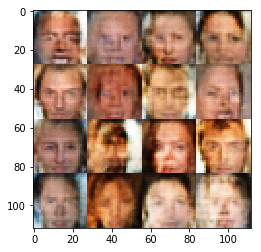

Epoch 0/1... Discriminator Loss: 1.0296... Generator Loss: 0.6643
Epoch 0/1... Discriminator Loss: 1.1678... Generator Loss: 0.7165
Epoch 0/1... Discriminator Loss: 1.2355... Generator Loss: 0.6208
Epoch 0/1... Discriminator Loss: 1.2964... Generator Loss: 0.4307
Epoch 0/1... Discriminator Loss: 1.0272... Generator Loss: 0.8642


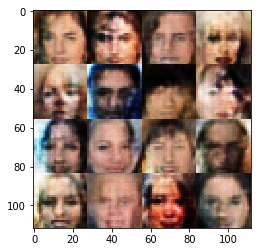

Epoch 0/1... Discriminator Loss: 1.3149... Generator Loss: 0.4368
Epoch 0/1... Discriminator Loss: 1.0417... Generator Loss: 1.2634
Epoch 0/1... Discriminator Loss: 1.2957... Generator Loss: 0.5088
Epoch 0/1... Discriminator Loss: 1.3730... Generator Loss: 0.5194
Epoch 0/1... Discriminator Loss: 1.0721... Generator Loss: 0.8733


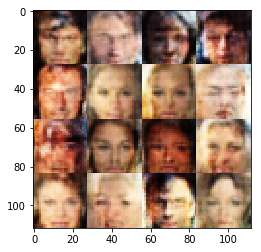

Epoch 0/1... Discriminator Loss: 1.2759... Generator Loss: 0.5371
Epoch 0/1... Discriminator Loss: 1.1915... Generator Loss: 0.5415
Epoch 0/1... Discriminator Loss: 1.0601... Generator Loss: 0.6048
Epoch 0/1... Discriminator Loss: 1.0250... Generator Loss: 0.7297
Epoch 0/1... Discriminator Loss: 1.2730... Generator Loss: 0.5960


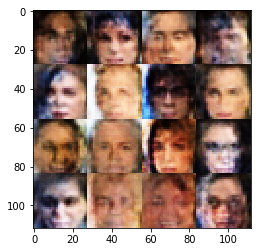

Epoch 0/1... Discriminator Loss: 1.2698... Generator Loss: 0.5897
Epoch 0/1... Discriminator Loss: 0.8446... Generator Loss: 1.2023
Epoch 0/1... Discriminator Loss: 1.0586... Generator Loss: 0.8178
Epoch 0/1... Discriminator Loss: 1.2468... Generator Loss: 0.6374
Epoch 0/1... Discriminator Loss: 0.7953... Generator Loss: 0.9641


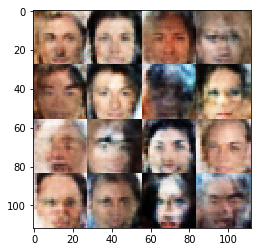

Epoch 0/1... Discriminator Loss: 0.8766... Generator Loss: 1.1153
Epoch 0/1... Discriminator Loss: 1.1736... Generator Loss: 0.6063
Epoch 0/1... Discriminator Loss: 1.1045... Generator Loss: 0.7064
Epoch 0/1... Discriminator Loss: 1.3563... Generator Loss: 0.5832
Epoch 0/1... Discriminator Loss: 0.9310... Generator Loss: 1.1718


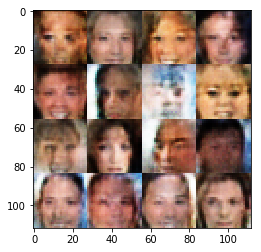

Epoch 0/1... Discriminator Loss: 2.0971... Generator Loss: 0.1806
Epoch 0/1... Discriminator Loss: 1.0142... Generator Loss: 0.9429
Epoch 0/1... Discriminator Loss: 1.3715... Generator Loss: 0.6195
Epoch 0/1... Discriminator Loss: 1.2936... Generator Loss: 0.5470
Epoch 0/1... Discriminator Loss: 1.2224... Generator Loss: 0.5837


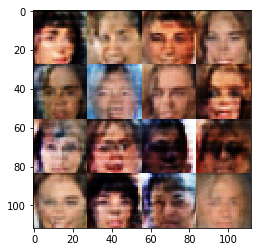

Epoch 0/1... Discriminator Loss: 1.2861... Generator Loss: 0.7143
Epoch 0/1... Discriminator Loss: 1.0401... Generator Loss: 1.3710
Epoch 0/1... Discriminator Loss: 1.1515... Generator Loss: 0.8885
Epoch 0/1... Discriminator Loss: 1.2836... Generator Loss: 0.4949
Epoch 0/1... Discriminator Loss: 1.2808... Generator Loss: 0.7905


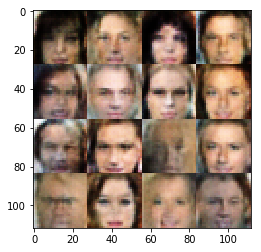

Epoch 0/1... Discriminator Loss: 0.9810... Generator Loss: 0.6835
Epoch 0/1... Discriminator Loss: 1.4246... Generator Loss: 0.4296
Epoch 0/1... Discriminator Loss: 0.6993... Generator Loss: 1.1086
Epoch 0/1... Discriminator Loss: 0.9113... Generator Loss: 1.0655
Epoch 0/1... Discriminator Loss: 1.4464... Generator Loss: 0.5584


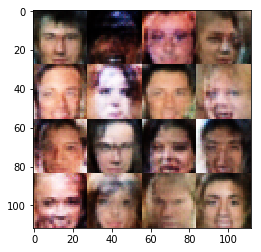

Epoch 0/1... Discriminator Loss: 1.6425... Generator Loss: 0.3164
Epoch 0/1... Discriminator Loss: 0.8954... Generator Loss: 1.1510
Epoch 0/1... Discriminator Loss: 1.1773... Generator Loss: 0.8240
Epoch 0/1... Discriminator Loss: 0.9730... Generator Loss: 0.6981
Epoch 0/1... Discriminator Loss: 1.1121... Generator Loss: 0.5928


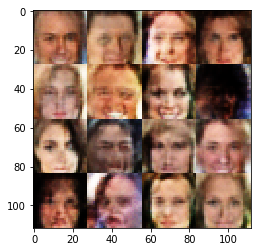

Epoch 0/1... Discriminator Loss: 1.8314... Generator Loss: 0.2758
Epoch 0/1... Discriminator Loss: 1.9462... Generator Loss: 0.3333
Epoch 0/1... Discriminator Loss: 1.2795... Generator Loss: 0.7191
Epoch 0/1... Discriminator Loss: 1.1683... Generator Loss: 0.7427
Epoch 0/1... Discriminator Loss: 0.9307... Generator Loss: 0.8858


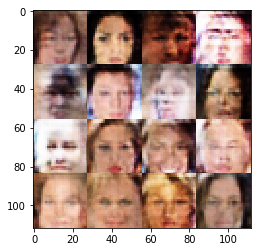

Epoch 0/1... Discriminator Loss: 1.0983... Generator Loss: 0.7505
Epoch 0/1... Discriminator Loss: 1.2399... Generator Loss: 0.9130
Epoch 0/1... Discriminator Loss: 1.5634... Generator Loss: 0.3336
Epoch 0/1... Discriminator Loss: 1.1984... Generator Loss: 0.6894
Epoch 0/1... Discriminator Loss: 0.7221... Generator Loss: 1.0634


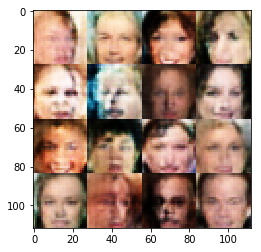

Epoch 0/1... Discriminator Loss: 1.0686... Generator Loss: 1.0882
Epoch 0/1... Discriminator Loss: 1.3037... Generator Loss: 0.6816
Epoch 0/1... Discriminator Loss: 1.2522... Generator Loss: 0.4480
Epoch 0/1... Discriminator Loss: 1.1714... Generator Loss: 0.8316
Epoch 0/1... Discriminator Loss: 1.2001... Generator Loss: 1.4353


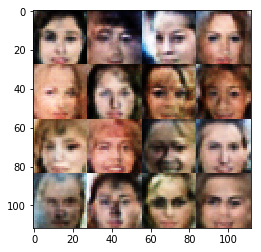

Epoch 0/1... Discriminator Loss: 1.3311... Generator Loss: 0.5622
Epoch 0/1... Discriminator Loss: 1.2388... Generator Loss: 0.5591
Epoch 0/1... Discriminator Loss: 1.5899... Generator Loss: 0.3136
Epoch 0/1... Discriminator Loss: 0.9116... Generator Loss: 0.9777
Epoch 0/1... Discriminator Loss: 0.7234... Generator Loss: 1.4737


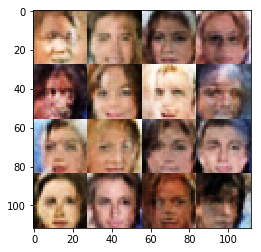

Epoch 0/1... Discriminator Loss: 1.3568... Generator Loss: 0.4165
Epoch 0/1... Discriminator Loss: 1.3531... Generator Loss: 0.4405
Epoch 0/1... Discriminator Loss: 1.1549... Generator Loss: 0.6469
Epoch 0/1... Discriminator Loss: 1.2901... Generator Loss: 0.5230
Epoch 0/1... Discriminator Loss: 0.9204... Generator Loss: 0.9138


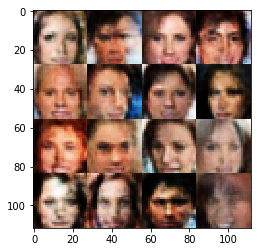

Epoch 0/1... Discriminator Loss: 1.6633... Generator Loss: 0.3246
Epoch 0/1... Discriminator Loss: 1.5044... Generator Loss: 0.4852
Epoch 0/1... Discriminator Loss: 0.9430... Generator Loss: 1.3591
Epoch 0/1... Discriminator Loss: 1.2575... Generator Loss: 0.5769
Epoch 0/1... Discriminator Loss: 1.0774... Generator Loss: 0.7221


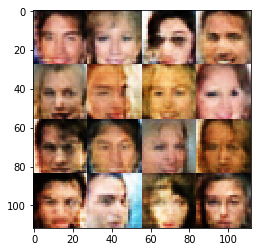

Epoch 0/1... Discriminator Loss: 0.9724... Generator Loss: 0.7006
Epoch 0/1... Discriminator Loss: 1.5111... Generator Loss: 0.3545
Epoch 0/1... Discriminator Loss: 0.9749... Generator Loss: 0.7045
Epoch 0/1... Discriminator Loss: 0.6485... Generator Loss: 1.4028
Epoch 0/1... Discriminator Loss: 1.5528... Generator Loss: 0.2902


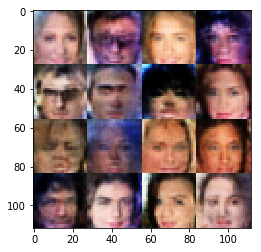

Epoch 0/1... Discriminator Loss: 1.2005... Generator Loss: 0.6029
Epoch 0/1... Discriminator Loss: 1.0856... Generator Loss: 0.7554
Epoch 0/1... Discriminator Loss: 1.0976... Generator Loss: 0.6746
Epoch 0/1... Discriminator Loss: 0.7453... Generator Loss: 1.1969
Epoch 0/1... Discriminator Loss: 1.2642... Generator Loss: 0.4431


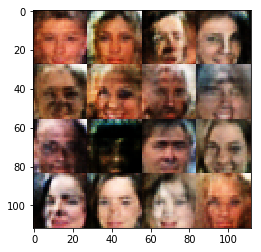

Epoch 0/1... Discriminator Loss: 1.1096... Generator Loss: 0.5313
Epoch 0/1... Discriminator Loss: 1.1467... Generator Loss: 1.0134
Epoch 0/1... Discriminator Loss: 1.3875... Generator Loss: 0.4788
Epoch 0/1... Discriminator Loss: 1.3861... Generator Loss: 0.8057
Epoch 0/1... Discriminator Loss: 1.4896... Generator Loss: 0.3699


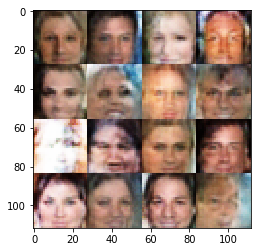

Epoch 0/1... Discriminator Loss: 0.9401... Generator Loss: 0.9480
Epoch 0/1... Discriminator Loss: 1.1725... Generator Loss: 0.8514
Epoch 0/1... Discriminator Loss: 0.9469... Generator Loss: 1.0633
Epoch 0/1... Discriminator Loss: 0.9111... Generator Loss: 0.8552
Epoch 0/1... Discriminator Loss: 1.1775... Generator Loss: 0.6146


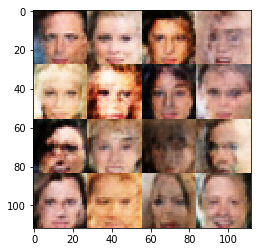

Epoch 0/1... Discriminator Loss: 1.1639... Generator Loss: 0.5849
Epoch 0/1... Discriminator Loss: 0.7062... Generator Loss: 1.5451
Epoch 0/1... Discriminator Loss: 1.2097... Generator Loss: 0.8066
Epoch 0/1... Discriminator Loss: 0.9851... Generator Loss: 1.5818
Epoch 0/1... Discriminator Loss: 1.5021... Generator Loss: 0.3446


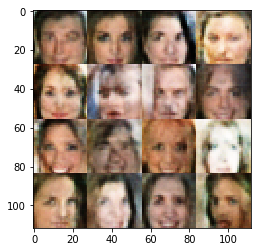

Epoch 0/1... Discriminator Loss: 1.0610... Generator Loss: 0.6780
Epoch 0/1... Discriminator Loss: 1.3209... Generator Loss: 0.5916
Epoch 0/1... Discriminator Loss: 1.0975... Generator Loss: 0.5725
Epoch 0/1... Discriminator Loss: 1.3222... Generator Loss: 0.4870
Epoch 0/1... Discriminator Loss: 1.8749... Generator Loss: 0.2221


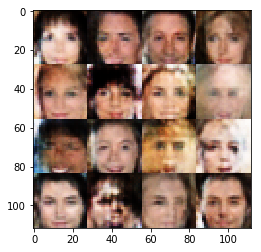

Epoch 0/1... Discriminator Loss: 1.1924... Generator Loss: 0.5335
Epoch 0/1... Discriminator Loss: 1.1267... Generator Loss: 0.6006
Epoch 0/1... Discriminator Loss: 1.0728... Generator Loss: 0.7684
Epoch 0/1... Discriminator Loss: 1.1040... Generator Loss: 0.5480
Epoch 0/1... Discriminator Loss: 1.2112... Generator Loss: 0.9407


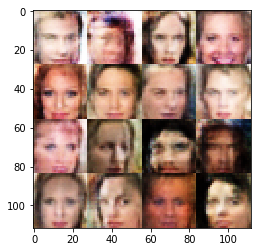

Epoch 0/1... Discriminator Loss: 1.1351... Generator Loss: 1.2107
Epoch 0/1... Discriminator Loss: 1.0395... Generator Loss: 1.1994
Epoch 0/1... Discriminator Loss: 0.8617... Generator Loss: 2.3018
Epoch 0/1... Discriminator Loss: 0.8954... Generator Loss: 1.2651
Epoch 0/1... Discriminator Loss: 1.1270... Generator Loss: 0.5602


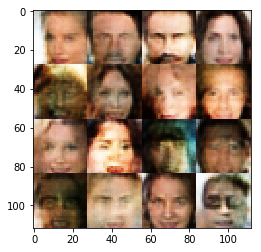

Epoch 0/1... Discriminator Loss: 0.8498... Generator Loss: 1.5877
Epoch 0/1... Discriminator Loss: 0.9680... Generator Loss: 1.0823
Epoch 0/1... Discriminator Loss: 1.2245... Generator Loss: 0.5310
Epoch 0/1... Discriminator Loss: 1.4091... Generator Loss: 1.0500
Epoch 0/1... Discriminator Loss: 1.1532... Generator Loss: 0.6367


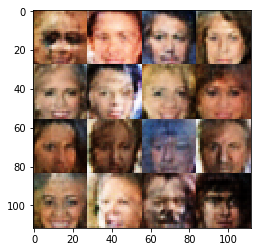

Epoch 0/1... Discriminator Loss: 1.0224... Generator Loss: 0.9471
Epoch 0/1... Discriminator Loss: 1.1190... Generator Loss: 1.4296
Epoch 0/1... Discriminator Loss: 0.7530... Generator Loss: 1.9976
Epoch 0/1... Discriminator Loss: 1.0608... Generator Loss: 0.7971
Epoch 0/1... Discriminator Loss: 1.0953... Generator Loss: 0.6577


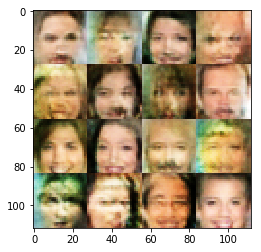

Epoch 0/1... Discriminator Loss: 1.1938... Generator Loss: 0.7491
Epoch 0/1... Discriminator Loss: 1.0446... Generator Loss: 0.6715
Epoch 0/1... Discriminator Loss: 1.0644... Generator Loss: 0.7915
Epoch 0/1... Discriminator Loss: 1.5751... Generator Loss: 1.5751
Epoch 0/1... Discriminator Loss: 1.0058... Generator Loss: 0.8698


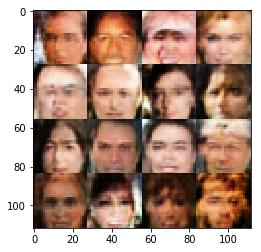

Epoch 0/1... Discriminator Loss: 0.7120... Generator Loss: 1.3090
Epoch 0/1... Discriminator Loss: 1.0372... Generator Loss: 0.8518
Epoch 0/1... Discriminator Loss: 0.9935... Generator Loss: 0.9392
Epoch 0/1... Discriminator Loss: 1.0896... Generator Loss: 0.8392
Epoch 0/1... Discriminator Loss: 0.9382... Generator Loss: 0.9526


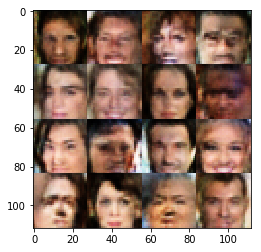

Epoch 0/1... Discriminator Loss: 1.0105... Generator Loss: 1.0497
Epoch 0/1... Discriminator Loss: 1.2580... Generator Loss: 0.5219
Epoch 0/1... Discriminator Loss: 1.1515... Generator Loss: 0.5280
Epoch 0/1... Discriminator Loss: 0.6847... Generator Loss: 1.0760
Epoch 0/1... Discriminator Loss: 1.0877... Generator Loss: 0.7630


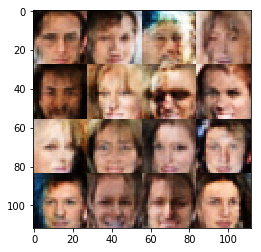

Epoch 0/1... Discriminator Loss: 1.6733... Generator Loss: 0.2411
Epoch 0/1... Discriminator Loss: 1.5478... Generator Loss: 0.4695
Epoch 0/1... Discriminator Loss: 1.1497... Generator Loss: 0.5833
Epoch 0/1... Discriminator Loss: 1.6806... Generator Loss: 0.2781
Epoch 0/1... Discriminator Loss: 1.2612... Generator Loss: 0.5049


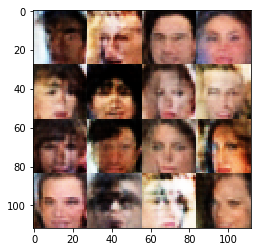

Epoch 0/1... Discriminator Loss: 1.2544... Generator Loss: 0.4707
Epoch 0/1... Discriminator Loss: 1.5229... Generator Loss: 0.3499
Epoch 0/1... Discriminator Loss: 1.7666... Generator Loss: 0.2732
Epoch 0/1... Discriminator Loss: 1.3459... Generator Loss: 0.4376
Epoch 0/1... Discriminator Loss: 1.5687... Generator Loss: 0.3854


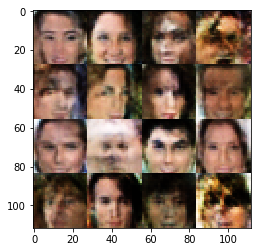

Epoch 0/1... Discriminator Loss: 1.5049... Generator Loss: 0.4066
Epoch 0/1... Discriminator Loss: 1.1448... Generator Loss: 0.6360
Epoch 0/1... Discriminator Loss: 1.0199... Generator Loss: 1.1672
Epoch 0/1... Discriminator Loss: 1.2082... Generator Loss: 0.6367
Epoch 0/1... Discriminator Loss: 1.5585... Generator Loss: 0.3623


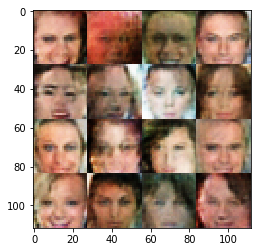

Epoch 0/1... Discriminator Loss: 1.3665... Generator Loss: 0.5064
Epoch 0/1... Discriminator Loss: 0.8773... Generator Loss: 0.9585
Epoch 0/1... Discriminator Loss: 1.1731... Generator Loss: 0.9543
Epoch 0/1... Discriminator Loss: 0.8999... Generator Loss: 0.8751
Epoch 0/1... Discriminator Loss: 1.4358... Generator Loss: 0.5499


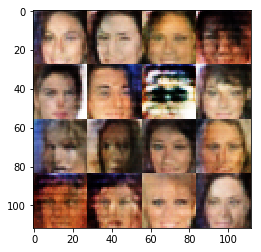

Epoch 0/1... Discriminator Loss: 0.7798... Generator Loss: 1.2251
Epoch 0/1... Discriminator Loss: 1.3604... Generator Loss: 0.3987
Epoch 0/1... Discriminator Loss: 1.0130... Generator Loss: 0.9049
Epoch 0/1... Discriminator Loss: 1.8094... Generator Loss: 0.2692
Epoch 0/1... Discriminator Loss: 1.0559... Generator Loss: 0.7702


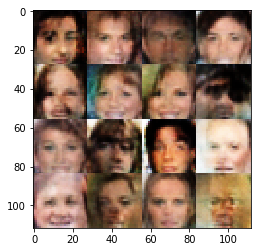

Epoch 0/1... Discriminator Loss: 1.2283... Generator Loss: 0.4712
Epoch 0/1... Discriminator Loss: 1.0323... Generator Loss: 0.7385
Epoch 0/1... Discriminator Loss: 1.5968... Generator Loss: 0.3021
Epoch 0/1... Discriminator Loss: 0.9739... Generator Loss: 0.6586
Epoch 0/1... Discriminator Loss: 0.6939... Generator Loss: 1.0289


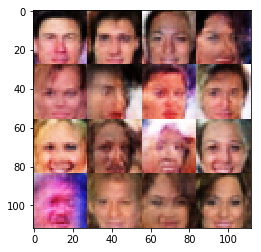

Epoch 0/1... Discriminator Loss: 0.9971... Generator Loss: 0.7013
Epoch 0/1... Discriminator Loss: 1.1232... Generator Loss: 1.0242
Epoch 0/1... Discriminator Loss: 0.8635... Generator Loss: 1.1205
Epoch 0/1... Discriminator Loss: 1.2811... Generator Loss: 0.6492
Epoch 0/1... Discriminator Loss: 1.1789... Generator Loss: 0.7928


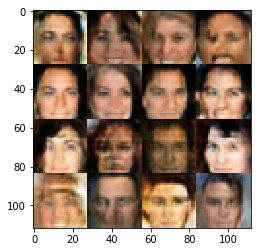

Epoch 0/1... Discriminator Loss: 0.9760... Generator Loss: 0.9572
Epoch 0/1... Discriminator Loss: 0.5943... Generator Loss: 1.2600
Epoch 0/1... Discriminator Loss: 1.2517... Generator Loss: 0.6501
Epoch 0/1... Discriminator Loss: 1.4576... Generator Loss: 0.4185
Epoch 0/1... Discriminator Loss: 1.4014... Generator Loss: 0.5533


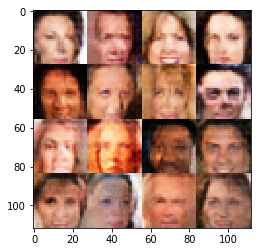

Epoch 0/1... Discriminator Loss: 1.1591... Generator Loss: 0.8889
Epoch 0/1... Discriminator Loss: 1.0351... Generator Loss: 1.0028
Epoch 0/1... Discriminator Loss: 1.0683... Generator Loss: 0.7247
Epoch 0/1... Discriminator Loss: 0.8094... Generator Loss: 1.0294
Epoch 0/1... Discriminator Loss: 0.8386... Generator Loss: 1.5855


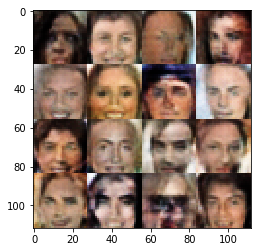

Epoch 0/1... Discriminator Loss: 0.7947... Generator Loss: 0.8494
Epoch 0/1... Discriminator Loss: 1.5246... Generator Loss: 0.3358
Epoch 0/1... Discriminator Loss: 1.0586... Generator Loss: 0.6847
Epoch 0/1... Discriminator Loss: 1.1414... Generator Loss: 0.7125
Epoch 0/1... Discriminator Loss: 0.9851... Generator Loss: 0.9061


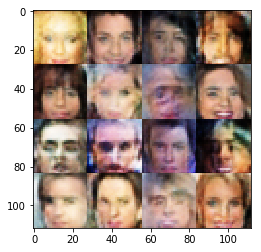

Epoch 0/1... Discriminator Loss: 0.9407... Generator Loss: 1.1953
Epoch 0/1... Discriminator Loss: 1.4674... Generator Loss: 0.4078
Epoch 0/1... Discriminator Loss: 1.1891... Generator Loss: 0.5880
Epoch 0/1... Discriminator Loss: 1.0517... Generator Loss: 1.2129
Epoch 0/1... Discriminator Loss: 1.2915... Generator Loss: 0.4140


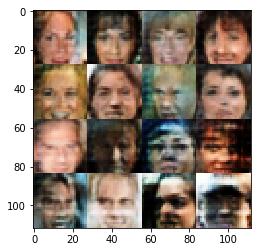

Epoch 0/1... Discriminator Loss: 1.6235... Generator Loss: 0.7043
Epoch 0/1... Discriminator Loss: 1.0343... Generator Loss: 0.8798
Epoch 0/1... Discriminator Loss: 1.3971... Generator Loss: 1.0086
Epoch 0/1... Discriminator Loss: 1.0324... Generator Loss: 0.8056
Epoch 0/1... Discriminator Loss: 1.0849... Generator Loss: 0.7174


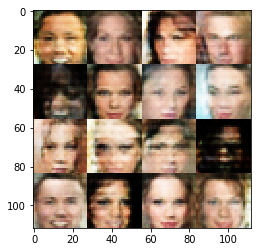

Epoch 0/1... Discriminator Loss: 1.1757... Generator Loss: 0.6376
Epoch 0/1... Discriminator Loss: 1.2557... Generator Loss: 0.5987
Epoch 0/1... Discriminator Loss: 1.1244... Generator Loss: 0.6911
Epoch 0/1... Discriminator Loss: 1.7204... Generator Loss: 0.3312
Epoch 0/1... Discriminator Loss: 0.9337... Generator Loss: 0.8706


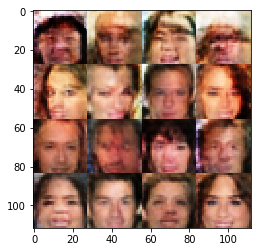

Epoch 0/1... Discriminator Loss: 1.1582... Generator Loss: 0.6400
Epoch 0/1... Discriminator Loss: 1.0109... Generator Loss: 0.9175
Epoch 0/1... Discriminator Loss: 1.2315... Generator Loss: 0.7024
Epoch 0/1... Discriminator Loss: 0.5272... Generator Loss: 1.3228
Epoch 0/1... Discriminator Loss: 0.9806... Generator Loss: 0.6550


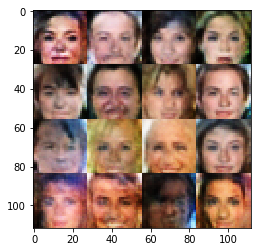

Epoch 0/1... Discriminator Loss: 1.0463... Generator Loss: 0.7381
Epoch 0/1... Discriminator Loss: 1.0910... Generator Loss: 0.8112
Epoch 0/1... Discriminator Loss: 1.0097... Generator Loss: 0.7342
Epoch 0/1... Discriminator Loss: 0.7764... Generator Loss: 1.3614
Epoch 0/1... Discriminator Loss: 1.4015... Generator Loss: 0.4011


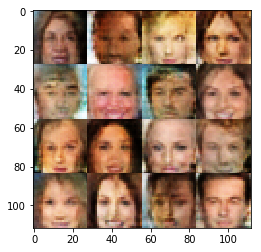

Epoch 0/1... Discriminator Loss: 1.0085... Generator Loss: 0.7708
Epoch 0/1... Discriminator Loss: 0.9636... Generator Loss: 0.9056
Epoch 0/1... Discriminator Loss: 0.7823... Generator Loss: 1.3092
Epoch 0/1... Discriminator Loss: 1.4890... Generator Loss: 0.3284
Epoch 0/1... Discriminator Loss: 0.8435... Generator Loss: 0.9271


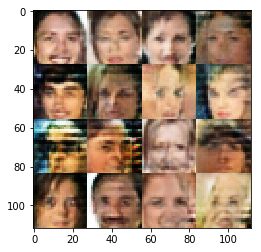

Epoch 0/1... Discriminator Loss: 0.9021... Generator Loss: 1.4528
Epoch 0/1... Discriminator Loss: 1.0994... Generator Loss: 0.7108
Epoch 0/1... Discriminator Loss: 1.1847... Generator Loss: 0.5519
Epoch 0/1... Discriminator Loss: 1.3079... Generator Loss: 0.6762
Epoch 0/1... Discriminator Loss: 1.2847... Generator Loss: 0.7330


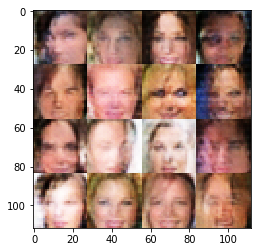

Epoch 0/1... Discriminator Loss: 1.3221... Generator Loss: 0.5211
Epoch 0/1... Discriminator Loss: 0.9649... Generator Loss: 0.8349
Epoch 0/1... Discriminator Loss: 1.2130... Generator Loss: 0.6592
Epoch 0/1... Discriminator Loss: 1.1228... Generator Loss: 0.6843
Epoch 0/1... Discriminator Loss: 0.8106... Generator Loss: 1.2004


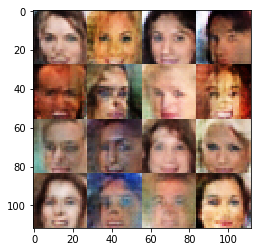

Epoch 0/1... Discriminator Loss: 1.1103... Generator Loss: 0.7104
Epoch 0/1... Discriminator Loss: 0.6919... Generator Loss: 1.4090
Epoch 0/1... Discriminator Loss: 1.6943... Generator Loss: 0.2777
Epoch 0/1... Discriminator Loss: 0.7956... Generator Loss: 0.8772
Epoch 0/1... Discriminator Loss: 0.8455... Generator Loss: 1.2046


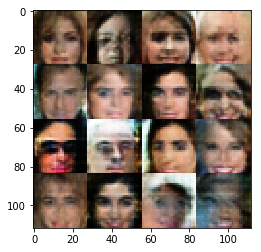

Epoch 0/1... Discriminator Loss: 1.0685... Generator Loss: 0.7465
Epoch 0/1... Discriminator Loss: 1.2006... Generator Loss: 0.5531
Epoch 0/1... Discriminator Loss: 1.5739... Generator Loss: 0.3622
Epoch 0/1... Discriminator Loss: 1.2451... Generator Loss: 0.5314
Epoch 0/1... Discriminator Loss: 0.9315... Generator Loss: 0.9001


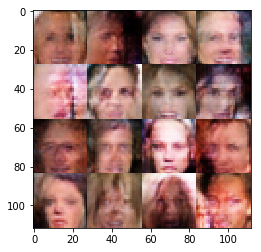

Epoch 0/1... Discriminator Loss: 1.4087... Generator Loss: 0.4355
Epoch 0/1... Discriminator Loss: 1.4114... Generator Loss: 0.3622
Epoch 0/1... Discriminator Loss: 1.0523... Generator Loss: 0.7260
Epoch 0/1... Discriminator Loss: 1.6725... Generator Loss: 0.2756
Epoch 0/1... Discriminator Loss: 1.2017... Generator Loss: 0.7295


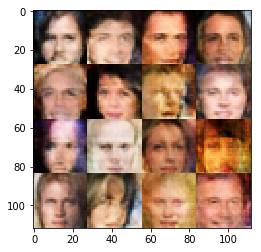

Epoch 0/1... Discriminator Loss: 0.8669... Generator Loss: 0.8806
Epoch 0/1... Discriminator Loss: 0.7204... Generator Loss: 1.1852
Epoch 0/1... Discriminator Loss: 1.6235... Generator Loss: 0.3193
Epoch 0/1... Discriminator Loss: 1.0763... Generator Loss: 0.7048
Epoch 0/1... Discriminator Loss: 1.2736... Generator Loss: 0.7229


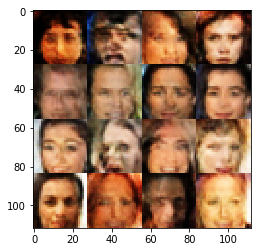

Epoch 0/1... Discriminator Loss: 1.2674... Generator Loss: 0.6908
Epoch 0/1... Discriminator Loss: 2.0594... Generator Loss: 0.1702
Epoch 0/1... Discriminator Loss: 0.9749... Generator Loss: 0.9690
Epoch 0/1... Discriminator Loss: 1.2975... Generator Loss: 0.5346
Epoch 0/1... Discriminator Loss: 1.4381... Generator Loss: 0.5077


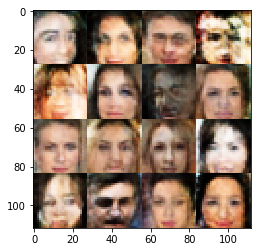

Epoch 0/1... Discriminator Loss: 0.6239... Generator Loss: 1.9230
Epoch 0/1... Discriminator Loss: 1.2997... Generator Loss: 0.6682
Epoch 0/1... Discriminator Loss: 1.0328... Generator Loss: 0.7033
Epoch 0/1... Discriminator Loss: 1.0373... Generator Loss: 0.6324
Epoch 0/1... Discriminator Loss: 1.3639... Generator Loss: 0.4048


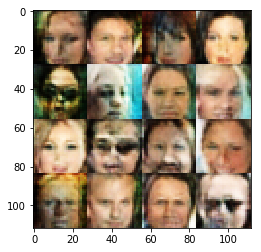

Epoch 0/1... Discriminator Loss: 1.6634... Generator Loss: 0.2694
Epoch 0/1... Discriminator Loss: 1.6430... Generator Loss: 0.3349
Epoch 0/1... Discriminator Loss: 1.1385... Generator Loss: 0.5419
Epoch 0/1... Discriminator Loss: 1.1436... Generator Loss: 0.6117
Epoch 0/1... Discriminator Loss: 0.7784... Generator Loss: 0.9013


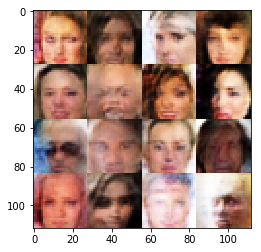

Epoch 0/1... Discriminator Loss: 0.9892... Generator Loss: 0.7972
Epoch 0/1... Discriminator Loss: 0.9015... Generator Loss: 1.0017
Epoch 0/1... Discriminator Loss: 1.2170... Generator Loss: 0.8406
Epoch 0/1... Discriminator Loss: 1.8741... Generator Loss: 0.2115
Epoch 0/1... Discriminator Loss: 1.2979... Generator Loss: 0.6113


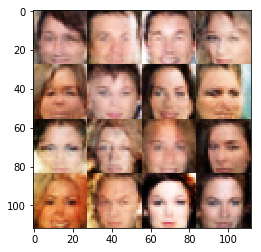

Epoch 0/1... Discriminator Loss: 0.7453... Generator Loss: 1.1235
Epoch 0/1... Discriminator Loss: 1.3884... Generator Loss: 0.3617
Epoch 0/1... Discriminator Loss: 1.1615... Generator Loss: 0.6557
Epoch 0/1... Discriminator Loss: 0.7222... Generator Loss: 1.2205
Epoch 0/1... Discriminator Loss: 1.1133... Generator Loss: 0.6097


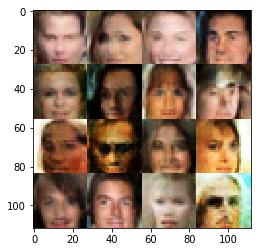

Epoch 0/1... Discriminator Loss: 0.8776... Generator Loss: 1.1156
Epoch 0/1... Discriminator Loss: 1.0772... Generator Loss: 0.9684
Epoch 0/1... Discriminator Loss: 1.1775... Generator Loss: 0.4684
Epoch 0/1... Discriminator Loss: 1.7335... Generator Loss: 0.2472
Epoch 0/1... Discriminator Loss: 1.0476... Generator Loss: 1.1300


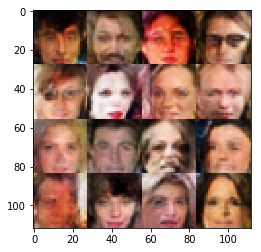

Epoch 0/1... Discriminator Loss: 1.2524... Generator Loss: 0.5855
Epoch 0/1... Discriminator Loss: 1.3342... Generator Loss: 0.5550
Epoch 0/1... Discriminator Loss: 1.0320... Generator Loss: 0.7888
Epoch 0/1... Discriminator Loss: 1.2536... Generator Loss: 0.4529
Epoch 0/1... Discriminator Loss: 0.9492... Generator Loss: 0.8876


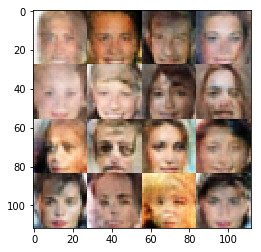

Epoch 0/1... Discriminator Loss: 1.2607... Generator Loss: 0.4750
Epoch 0/1... Discriminator Loss: 1.3874... Generator Loss: 0.4030
Epoch 0/1... Discriminator Loss: 1.3294... Generator Loss: 0.7899
Epoch 0/1... Discriminator Loss: 1.2346... Generator Loss: 0.5593
Epoch 0/1... Discriminator Loss: 1.1230... Generator Loss: 1.3903


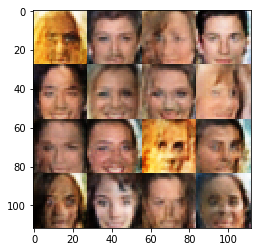

Epoch 0/1... Discriminator Loss: 1.3162... Generator Loss: 0.6751
Epoch 0/1... Discriminator Loss: 1.3562... Generator Loss: 0.4796
Epoch 0/1... Discriminator Loss: 0.8821... Generator Loss: 0.8109
Epoch 0/1... Discriminator Loss: 0.8215... Generator Loss: 1.2980
Epoch 0/1... Discriminator Loss: 1.3723... Generator Loss: 0.4261


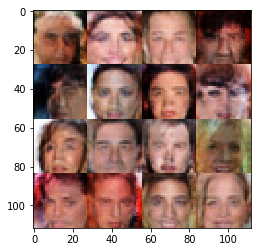

Epoch 0/1... Discriminator Loss: 1.2857... Generator Loss: 0.5370
Epoch 0/1... Discriminator Loss: 0.8210... Generator Loss: 1.0847
Epoch 0/1... Discriminator Loss: 1.0965... Generator Loss: 0.7059
Epoch 0/1... Discriminator Loss: 1.6238... Generator Loss: 0.3352
Epoch 0/1... Discriminator Loss: 1.5076... Generator Loss: 0.3429


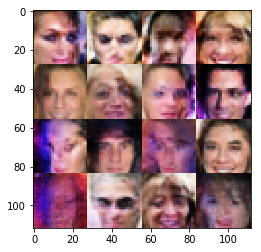

Epoch 0/1... Discriminator Loss: 1.3147... Generator Loss: 0.5145
Epoch 0/1... Discriminator Loss: 0.8649... Generator Loss: 1.0277
Epoch 0/1... Discriminator Loss: 1.2778... Generator Loss: 0.4547
Epoch 0/1... Discriminator Loss: 1.5500... Generator Loss: 0.3540
Epoch 0/1... Discriminator Loss: 1.1407... Generator Loss: 0.5422


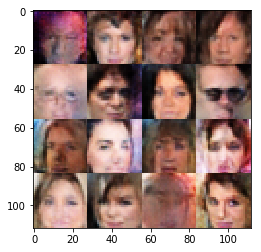

Epoch 0/1... Discriminator Loss: 1.0404... Generator Loss: 0.7500
Epoch 0/1... Discriminator Loss: 1.0035... Generator Loss: 0.7941
Epoch 0/1... Discriminator Loss: 1.0909... Generator Loss: 0.7353
Epoch 0/1... Discriminator Loss: 1.3165... Generator Loss: 0.4332
Epoch 0/1... Discriminator Loss: 0.9399... Generator Loss: 0.9175


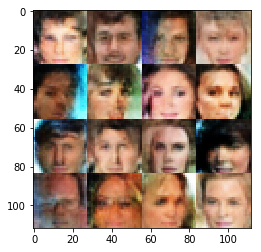

Epoch 0/1... Discriminator Loss: 1.4921... Generator Loss: 0.4176
Epoch 0/1... Discriminator Loss: 1.4919... Generator Loss: 0.4123
Epoch 0/1... Discriminator Loss: 1.5937... Generator Loss: 0.3735
Epoch 0/1... Discriminator Loss: 1.2023... Generator Loss: 0.5762
Epoch 0/1... Discriminator Loss: 1.5831... Generator Loss: 0.3653


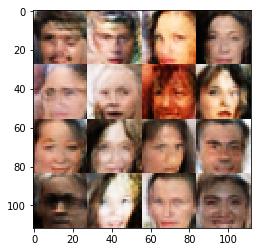

Epoch 0/1... Discriminator Loss: 1.2308... Generator Loss: 0.8998
Epoch 0/1... Discriminator Loss: 1.5575... Generator Loss: 0.3276
Epoch 0/1... Discriminator Loss: 1.4154... Generator Loss: 0.4974
Epoch 0/1... Discriminator Loss: 0.9207... Generator Loss: 0.8381
Epoch 0/1... Discriminator Loss: 1.1162... Generator Loss: 0.6288


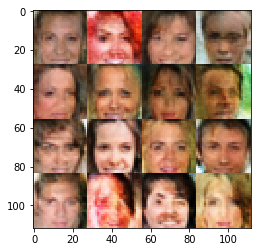

Epoch 0/1... Discriminator Loss: 1.4223... Generator Loss: 0.4787
Epoch 0/1... Discriminator Loss: 1.5341... Generator Loss: 0.3926
Epoch 0/1... Discriminator Loss: 0.9928... Generator Loss: 0.6856
Epoch 0/1... Discriminator Loss: 1.0130... Generator Loss: 0.8467
Epoch 0/1... Discriminator Loss: 1.2320... Generator Loss: 0.5316


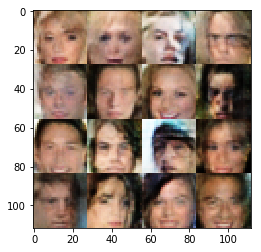

Epoch 0/1... Discriminator Loss: 1.3888... Generator Loss: 0.4632
Epoch 0/1... Discriminator Loss: 1.3049... Generator Loss: 0.4928
Epoch 0/1... Discriminator Loss: 1.3465... Generator Loss: 0.5279
Epoch 0/1... Discriminator Loss: 1.1423... Generator Loss: 0.6065
Epoch 0/1... Discriminator Loss: 0.9215... Generator Loss: 0.9961


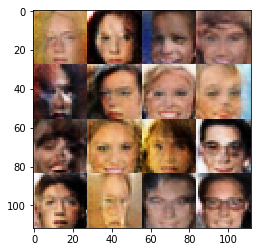

Epoch 0/1... Discriminator Loss: 1.0395... Generator Loss: 0.6710
Epoch 0/1... Discriminator Loss: 1.1460... Generator Loss: 1.1101
Epoch 0/1... Discriminator Loss: 1.2720... Generator Loss: 0.4866
Epoch 0/1... Discriminator Loss: 1.0859... Generator Loss: 0.6812
Epoch 0/1... Discriminator Loss: 1.2993... Generator Loss: 0.5562


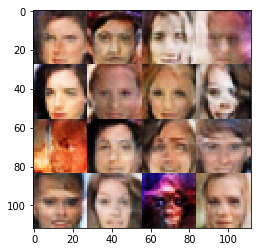

Epoch 0/1... Discriminator Loss: 1.1464... Generator Loss: 0.6020
Epoch 0/1... Discriminator Loss: 1.4251... Generator Loss: 0.3570
Epoch 0/1... Discriminator Loss: 0.8029... Generator Loss: 1.1437
Epoch 0/1... Discriminator Loss: 0.8257... Generator Loss: 0.8222
Epoch 0/1... Discriminator Loss: 1.2047... Generator Loss: 0.7708


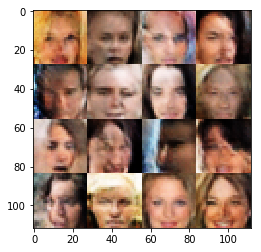

Epoch 0/1... Discriminator Loss: 1.4558... Generator Loss: 0.3237
Epoch 0/1... Discriminator Loss: 1.7219... Generator Loss: 0.2550
Epoch 0/1... Discriminator Loss: 1.1517... Generator Loss: 0.9060
Epoch 0/1... Discriminator Loss: 1.6473... Generator Loss: 0.3955
Epoch 0/1... Discriminator Loss: 1.3262... Generator Loss: 0.4407


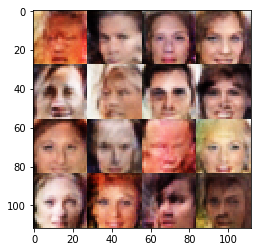

Epoch 0/1... Discriminator Loss: 1.2287... Generator Loss: 0.5697
Epoch 0/1... Discriminator Loss: 1.1695... Generator Loss: 0.8609
Epoch 0/1... Discriminator Loss: 1.1846... Generator Loss: 1.0027
Epoch 0/1... Discriminator Loss: 1.2729... Generator Loss: 0.5942
Epoch 0/1... Discriminator Loss: 1.2347... Generator Loss: 0.7128


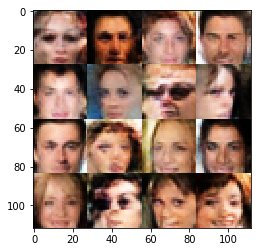

Epoch 0/1... Discriminator Loss: 0.9013... Generator Loss: 0.8290
Epoch 0/1... Discriminator Loss: 1.0378... Generator Loss: 0.9504
Epoch 0/1... Discriminator Loss: 0.9718... Generator Loss: 0.7987
Epoch 0/1... Discriminator Loss: 1.4085... Generator Loss: 0.4124
Epoch 0/1... Discriminator Loss: 1.1926... Generator Loss: 0.6687


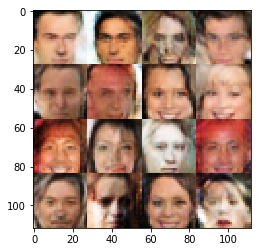

Epoch 0/1... Discriminator Loss: 0.9503... Generator Loss: 0.7805
Epoch 0/1... Discriminator Loss: 1.2289... Generator Loss: 0.6233
Epoch 0/1... Discriminator Loss: 1.1344... Generator Loss: 0.6876
Epoch 0/1... Discriminator Loss: 1.5289... Generator Loss: 0.3785
Epoch 0/1... Discriminator Loss: 1.1217... Generator Loss: 0.5623


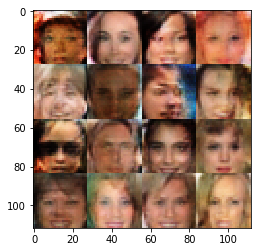

Epoch 0/1... Discriminator Loss: 1.0975... Generator Loss: 0.7909
Epoch 0/1... Discriminator Loss: 0.8227... Generator Loss: 0.9789
Epoch 0/1... Discriminator Loss: 1.3778... Generator Loss: 0.3838
Epoch 0/1... Discriminator Loss: 0.9786... Generator Loss: 1.0896
Epoch 0/1... Discriminator Loss: 0.8221... Generator Loss: 1.4171


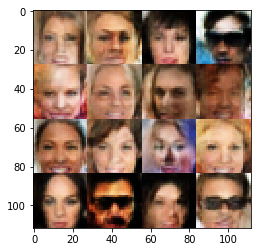

Epoch 0/1... Discriminator Loss: 1.4467... Generator Loss: 0.3737
Epoch 0/1... Discriminator Loss: 1.2805... Generator Loss: 0.5092
Epoch 0/1... Discriminator Loss: 1.1396... Generator Loss: 0.5677
Epoch 0/1... Discriminator Loss: 0.7404... Generator Loss: 1.1508
Epoch 0/1... Discriminator Loss: 1.0733... Generator Loss: 0.6830


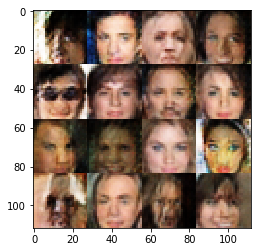

Epoch 0/1... Discriminator Loss: 0.9956... Generator Loss: 0.7606
Epoch 0/1... Discriminator Loss: 1.2241... Generator Loss: 0.7406
Epoch 0/1... Discriminator Loss: 1.0224... Generator Loss: 0.7035
Epoch 0/1... Discriminator Loss: 1.0500... Generator Loss: 0.6801
Epoch 0/1... Discriminator Loss: 1.5783... Generator Loss: 0.3007


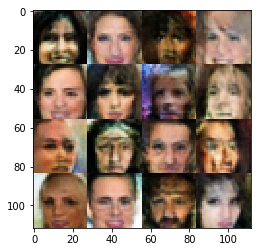

Epoch 0/1... Discriminator Loss: 1.1028... Generator Loss: 0.7669
Epoch 0/1... Discriminator Loss: 0.9341... Generator Loss: 0.8598
Epoch 0/1... Discriminator Loss: 1.3488... Generator Loss: 0.6854
Epoch 0/1... Discriminator Loss: 0.9911... Generator Loss: 0.9471
Epoch 0/1... Discriminator Loss: 0.9151... Generator Loss: 0.7193


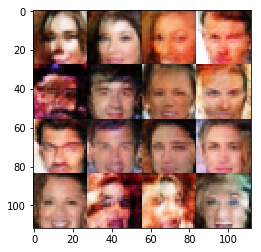

Epoch 0/1... Discriminator Loss: 1.2980... Generator Loss: 0.7393
Epoch 0/1... Discriminator Loss: 1.2070... Generator Loss: 0.6312
Epoch 0/1... Discriminator Loss: 0.6511... Generator Loss: 1.1417
Epoch 0/1... Discriminator Loss: 1.4601... Generator Loss: 0.3454
Epoch 0/1... Discriminator Loss: 0.9681... Generator Loss: 0.9037


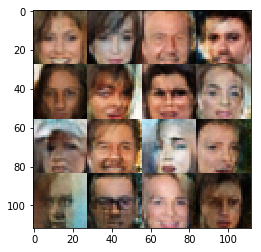

Epoch 0/1... Discriminator Loss: 1.2418... Generator Loss: 0.8481
Epoch 0/1... Discriminator Loss: 1.2821... Generator Loss: 0.4314
Epoch 0/1... Discriminator Loss: 0.9196... Generator Loss: 0.8532
Epoch 0/1... Discriminator Loss: 1.0788... Generator Loss: 0.7901
Epoch 0/1... Discriminator Loss: 0.9479... Generator Loss: 0.7617


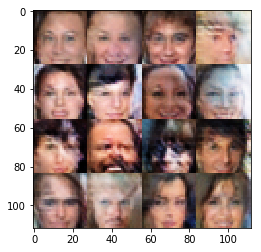

Epoch 0/1... Discriminator Loss: 1.4520... Generator Loss: 0.3823
Epoch 0/1... Discriminator Loss: 1.0976... Generator Loss: 0.7407
Epoch 0/1... Discriminator Loss: 1.1644... Generator Loss: 0.5668
Epoch 0/1... Discriminator Loss: 1.4043... Generator Loss: 0.5093
Epoch 0/1... Discriminator Loss: 1.2548... Generator Loss: 0.8468


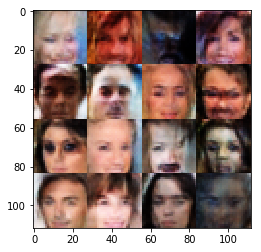

Epoch 0/1... Discriminator Loss: 1.7441... Generator Loss: 0.2546
Epoch 0/1... Discriminator Loss: 1.4112... Generator Loss: 0.4335
Epoch 0/1... Discriminator Loss: 1.2434... Generator Loss: 0.5669
Epoch 0/1... Discriminator Loss: 1.3462... Generator Loss: 0.5054
Epoch 0/1... Discriminator Loss: 1.5689... Generator Loss: 0.4047


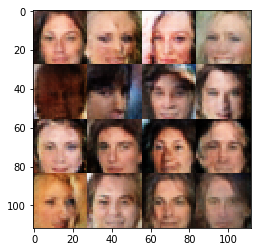

Epoch 0/1... Discriminator Loss: 1.4877... Generator Loss: 0.4014
Epoch 0/1... Discriminator Loss: 1.3946... Generator Loss: 0.6868
Epoch 0/1... Discriminator Loss: 1.1992... Generator Loss: 0.7536
Epoch 0/1... Discriminator Loss: 1.2493... Generator Loss: 0.5703
Epoch 0/1... Discriminator Loss: 1.2570... Generator Loss: 0.5532


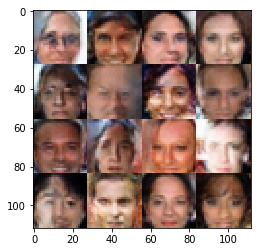

Epoch 0/1... Discriminator Loss: 1.3967... Generator Loss: 0.3933
Epoch 0/1... Discriminator Loss: 1.0864... Generator Loss: 0.6867
Epoch 0/1... Discriminator Loss: 1.1662... Generator Loss: 0.6010
Epoch 0/1... Discriminator Loss: 1.1503... Generator Loss: 0.6827
Epoch 0/1... Discriminator Loss: 0.9832... Generator Loss: 0.8200


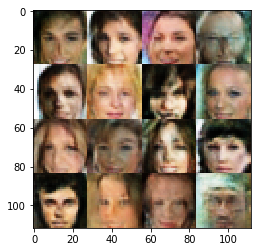

Epoch 0/1... Discriminator Loss: 1.1728... Generator Loss: 1.3253
Epoch 0/1... Discriminator Loss: 1.3174... Generator Loss: 0.5697
Epoch 0/1... Discriminator Loss: 1.2438... Generator Loss: 0.5414
Epoch 0/1... Discriminator Loss: 1.3645... Generator Loss: 0.5099
Epoch 0/1... Discriminator Loss: 1.3179... Generator Loss: 0.4995


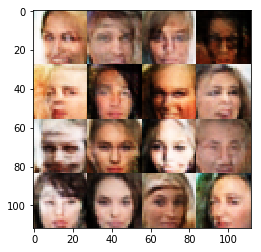

Epoch 0/1... Discriminator Loss: 1.0831... Generator Loss: 0.8843
Epoch 0/1... Discriminator Loss: 1.1668... Generator Loss: 0.7638
Epoch 0/1... Discriminator Loss: 0.9141... Generator Loss: 1.0014
Epoch 0/1... Discriminator Loss: 1.8814... Generator Loss: 0.2418
Epoch 0/1... Discriminator Loss: 1.4513... Generator Loss: 0.4185


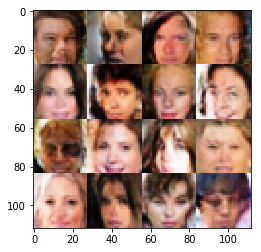

Epoch 0/1... Discriminator Loss: 1.4455... Generator Loss: 0.4951
Epoch 0/1... Discriminator Loss: 0.7752... Generator Loss: 1.0316
Epoch 0/1... Discriminator Loss: 1.1968... Generator Loss: 0.5326
Epoch 0/1... Discriminator Loss: 1.1297... Generator Loss: 0.5371
Epoch 0/1... Discriminator Loss: 1.2542... Generator Loss: 0.5559


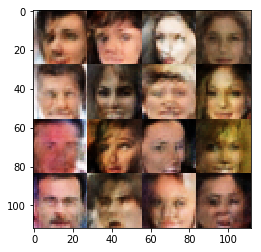

Epoch 0/1... Discriminator Loss: 1.6852... Generator Loss: 0.3204
Epoch 0/1... Discriminator Loss: 2.2339... Generator Loss: 0.2239
Epoch 0/1... Discriminator Loss: 1.1653... Generator Loss: 0.6184
Epoch 0/1... Discriminator Loss: 0.8331... Generator Loss: 1.0808
Epoch 0/1... Discriminator Loss: 1.4976... Generator Loss: 0.3170


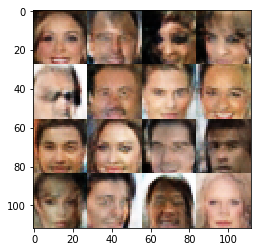

Epoch 0/1... Discriminator Loss: 1.1674... Generator Loss: 0.5569
Epoch 0/1... Discriminator Loss: 1.0366... Generator Loss: 0.6578
Epoch 0/1... Discriminator Loss: 1.1557... Generator Loss: 0.6811
Epoch 0/1... Discriminator Loss: 1.0882... Generator Loss: 0.6470
Epoch 0/1... Discriminator Loss: 2.0588... Generator Loss: 0.1882


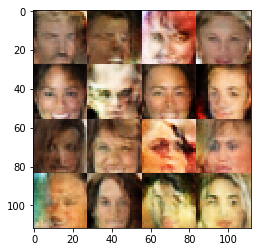

Epoch 0/1... Discriminator Loss: 1.1429... Generator Loss: 0.9140
Epoch 0/1... Discriminator Loss: 1.1394... Generator Loss: 1.0276
Epoch 0/1... Discriminator Loss: 1.2043... Generator Loss: 0.6293
Epoch 0/1... Discriminator Loss: 1.3613... Generator Loss: 0.4861
Epoch 0/1... Discriminator Loss: 1.0821... Generator Loss: 0.8504


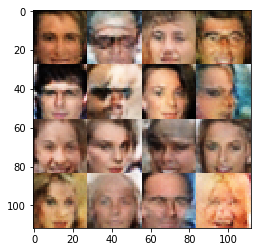

Epoch 0/1... Discriminator Loss: 0.7372... Generator Loss: 1.1098
Epoch 0/1... Discriminator Loss: 1.0271... Generator Loss: 0.7734
Epoch 0/1... Discriminator Loss: 1.1061... Generator Loss: 0.6242
Epoch 0/1... Discriminator Loss: 0.9994... Generator Loss: 0.6984
Epoch 0/1... Discriminator Loss: 1.0867... Generator Loss: 0.7282


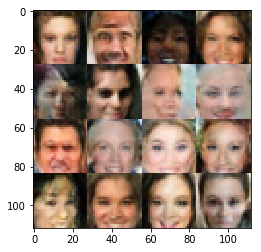

Epoch 0/1... Discriminator Loss: 1.3798... Generator Loss: 0.4336
Epoch 0/1... Discriminator Loss: 0.9738... Generator Loss: 1.2520
Epoch 0/1... Discriminator Loss: 1.1093... Generator Loss: 1.7306
Epoch 0/1... Discriminator Loss: 0.9451... Generator Loss: 0.9203
Epoch 0/1... Discriminator Loss: 1.5087... Generator Loss: 0.3563


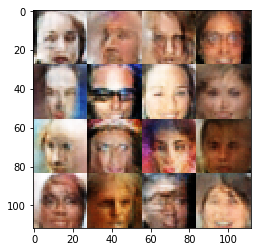

Epoch 0/1... Discriminator Loss: 1.0843... Generator Loss: 0.8069
Epoch 0/1... Discriminator Loss: 1.1940... Generator Loss: 0.6617
Epoch 0/1... Discriminator Loss: 0.8724... Generator Loss: 0.8089
Epoch 0/1... Discriminator Loss: 1.4122... Generator Loss: 0.4903
Epoch 0/1... Discriminator Loss: 1.1771... Generator Loss: 0.5837


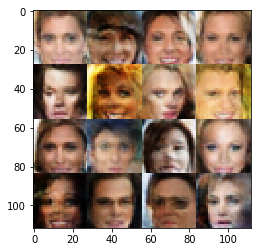

Epoch 0/1... Discriminator Loss: 1.0976... Generator Loss: 0.7479
Epoch 0/1... Discriminator Loss: 1.1963... Generator Loss: 0.5595
Epoch 0/1... Discriminator Loss: 1.2208... Generator Loss: 0.8965
Epoch 0/1... Discriminator Loss: 1.5188... Generator Loss: 0.3350
Epoch 0/1... Discriminator Loss: 0.9605... Generator Loss: 0.7073


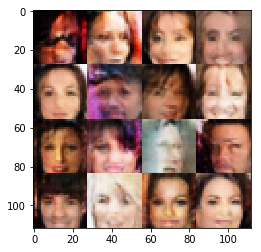

Epoch 0/1... Discriminator Loss: 1.4072... Generator Loss: 0.4761
Epoch 0/1... Discriminator Loss: 1.2741... Generator Loss: 0.4796
Epoch 0/1... Discriminator Loss: 1.3023... Generator Loss: 0.4347
Epoch 0/1... Discriminator Loss: 0.6721... Generator Loss: 1.8522
Epoch 0/1... Discriminator Loss: 0.9257... Generator Loss: 0.9075


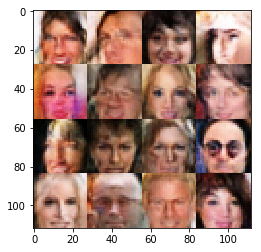

Epoch 0/1... Discriminator Loss: 1.1368... Generator Loss: 0.5179
Epoch 0/1... Discriminator Loss: 1.3827... Generator Loss: 0.4617
Epoch 0/1... Discriminator Loss: 1.4848... Generator Loss: 0.4394
Epoch 0/1... Discriminator Loss: 0.8303... Generator Loss: 1.0485
Epoch 0/1... Discriminator Loss: 1.7526... Generator Loss: 0.7355


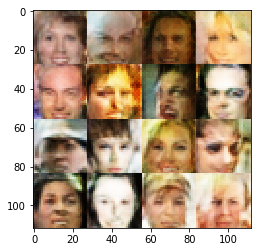

Epoch 0/1... Discriminator Loss: 1.5287... Generator Loss: 0.3071
Epoch 0/1... Discriminator Loss: 1.1593... Generator Loss: 0.5231
Epoch 0/1... Discriminator Loss: 1.3673... Generator Loss: 0.6120
Epoch 0/1... Discriminator Loss: 1.1761... Generator Loss: 0.7583


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.